In [1]:
import datetime
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpre
import math
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import dtw as dtw1

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Variables

df: original dataset <br>
dfc: copy we created to substitute NaN to -200 for the missing values for heatmap and counting missing values


# Data Understanding

In [2]:
#Opening the dataset
df=pd.read_csv('C:/Users/Christian/Desktop/Università/DATA SCIENCE/DA DARE/3. DM II/uci-air-quality/uci-air-quality/data/airqualityuci.csv')

In [3]:
dfc=copy.deepcopy(df) #I make a copy where I substitute to -200 the NaN value
df

date      time  co_gt  pt08_s1_co  nmhc_gt  c6h6_gt  pt08_s2_nmhc  \
0     2004-03-10  18.00.00    2.6        1360      150     11.9          1046   
1     2004-03-10  19.00.00    2.0        1292      112      9.4           955   
2     2004-03-10  20.00.00    2.2        1402       88      9.0           939   
3     2004-03-10  21.00.00    2.2        1376       80      9.2           948   
4     2004-03-10  22.00.00    1.6        1272       51      6.5           836   
...          ...       ...    ...         ...      ...      ...           ...   
9352  2005-04-04  10.00.00    3.1        1314     -200     13.5          1101   
9353  2005-04-04  11.00.00    2.4        1163     -200     11.4          1027   
9354  2005-04-04  12.00.00    2.4        1142     -200     12.4          1063   
9355  2005-04-04  13.00.00    2.1        1003     -200      9.5           961   
9356  2005-04-04  14.00.00    2.2        1071     -200     11.9          1047   

      nox_gt  pt08_s3_nox  no2_gt  pt08_s4_no2  pt08_s5_o3     t    rh      ah  
0        166         1056     113         1692        1268  13.6  48.9  0.7578  
1        103         1174      92         1559         972  13.3  47.7  0.7255  
2        131         1140     114         1555        1074  11.9  54.0  0.7502  
3        172         1092     122         1584        1203  11.0  60.0  0.7867  
4        131         1205     116         1490        1110  11.2  59.6  0.7888  
...      ...          ...     ...          ...         ...   ...   ...     ...  
9352     472          539     190         1374        1729  21.9  29.3  0.7568  
9353     353          604     179         1264        1269  24.3  23.7  0.7119  
9354     293          603     175         1241        1092  26.9  18.3  0.6406  
9355     235          702     156         1041         770  28.3  13.5  0.5139  
9356     265          654     168         1129         816  28.5  13.1  0.5028  

[9357 rows x 15 columns]

In [4]:
#In order to understand how many missing values there are we substitute -200 with NaN, so that functions regarding null
#values can be used
dfc=dfc.replace(-200,np.nan)
#We extract the names of the features
column_names=list(dfc.columns)
#We count the number of missing values and turn them into an array
missingvaluescount=dfc.isnull().sum().to_numpy()
#We put everything in a dataframe, considering the feature, the number of MV and the relative percentage of MV over all 
#the different values
dfpercentages=pd.DataFrame({'Attributes':[a for a in column_names],'missingvalues':[a for a in missingvaluescount], 'percentage':[ "{0:.2f}%".format((a/len(dfc))*100) for a in missingvaluescount]})
dfpercentages

Attributes  missingvalues percentage
0           date              0      0.00%
1           time              0      0.00%
2          co_gt           1683     17.99%
3     pt08_s1_co            366      3.91%
4        nmhc_gt           8443     90.23%
5        c6h6_gt            366      3.91%
6   pt08_s2_nmhc            366      3.91%
7         nox_gt           1639     17.52%
8    pt08_s3_nox            366      3.91%
9         no2_gt           1642     17.55%
10   pt08_s4_no2            366      3.91%
11    pt08_s5_o3            366      3.91%
12             t            366      3.91%
13            rh            366      3.91%
14            ah            366      3.91%

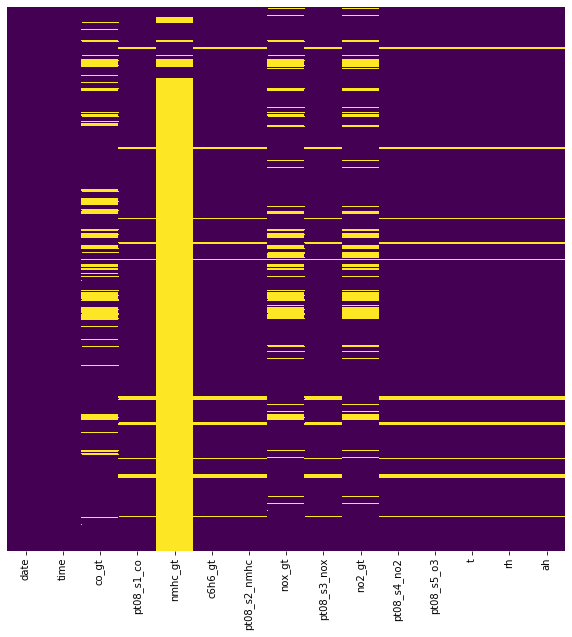

In [5]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(dfc.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#fig.savefig('C:/Users/Christian/Plots/heatmap.png',dpi=150)

In [6]:
dfc['time'] = pd.to_datetime(dfc['time'],format= '%H.%M.%S').dt.hour
dfc['date'] = pd.to_datetime(dfc['date'])

In [7]:
dfc.describe()

time        co_gt   pt08_s1_co      nmhc_gt      c6h6_gt  \
count  9357.000000  7674.000000  8991.000000   914.000000  8991.000000   
mean     11.498557     2.152750  1099.833166   218.811816    10.083105   
std       6.923182     1.453252   217.080037   204.459921     7.449820   
min       0.000000     0.100000   647.000000     7.000000     0.100000   
25%       5.000000     1.100000   937.000000    67.000000     4.400000   
50%      11.000000     1.800000  1063.000000   150.000000     8.200000   
75%      18.000000     2.900000  1231.000000   297.000000    14.000000   
max      23.000000    11.900000  2040.000000  1189.000000    63.700000   

       pt08_s2_nmhc       nox_gt  pt08_s3_nox       no2_gt  pt08_s4_no2  \
count   8991.000000  7718.000000  8991.000000  7715.000000  8991.000000   
mean     939.153376   246.896735   835.493605   113.091251  1456.264598   
std      266.831429   212.979168   256.817320    48.370108   346.206794   
min      383.000000     2.000000   322.000000     2.000000   551.000000   
25%      734.500000    98.000000   658.000000    78.000000  1227.000000   
50%      909.000000   180.000000   806.000000   109.000000  1463.000000   
75%     1116.000000   326.000000   969.500000   142.000000  1674.000000   
max     2214.000000  1479.000000  2683.000000   340.000000  2775.000000   

        pt08_s5_o3            t           rh           ah  
count  8991.000000  8991.000000  8991.000000  8991.000000  
mean   1022.906128    18.317829    49.234201     1.025530  
std     398.484288     8.832116    17.316892     0.403813  
min     221.000000    -1.900000     9.200000     0.184700  
25%     731.500000    11.800000    35.800000     0.736800  
50%     963.000000    17.800000    49.600000     0.995400  
75%    1273.500000    24.400000    62.500000     1.313700  
max    2523.000000    44.600000    88.700000     2.231000

In [8]:
df=df.drop(['nmhc_gt'],axis=1)
dfc=dfc.drop(['nmhc_gt'],axis=1)

In [9]:
dfc=dfc.dropna()
dfc

date  time  co_gt  pt08_s1_co  c6h6_gt  pt08_s2_nmhc  nox_gt  \
0    2004-03-10    18    2.6      1360.0     11.9        1046.0   166.0   
1    2004-03-10    19    2.0      1292.0      9.4         955.0   103.0   
2    2004-03-10    20    2.2      1402.0      9.0         939.0   131.0   
3    2004-03-10    21    2.2      1376.0      9.2         948.0   172.0   
4    2004-03-10    22    1.6      1272.0      6.5         836.0   131.0   
...         ...   ...    ...         ...      ...           ...     ...   
9352 2005-04-04    10    3.1      1314.0     13.5        1101.0   472.0   
9353 2005-04-04    11    2.4      1163.0     11.4        1027.0   353.0   
9354 2005-04-04    12    2.4      1142.0     12.4        1063.0   293.0   
9355 2005-04-04    13    2.1      1003.0      9.5         961.0   235.0   
9356 2005-04-04    14    2.2      1071.0     11.9        1047.0   265.0   

      pt08_s3_nox  no2_gt  pt08_s4_no2  pt08_s5_o3     t    rh      ah  
0          1056.0   113.0       1692.0      1268.0  13.6  48.9  0.7578  
1          1174.0    92.0       1559.0       972.0  13.3  47.7  0.7255  
2          1140.0   114.0       1555.0      1074.0  11.9  54.0  0.7502  
3          1092.0   122.0       1584.0      1203.0  11.0  60.0  0.7867  
4          1205.0   116.0       1490.0      1110.0  11.2  59.6  0.7888  
...           ...     ...          ...         ...   ...   ...     ...  
9352        539.0   190.0       1374.0      1729.0  21.9  29.3  0.7568  
9353        604.0   179.0       1264.0      1269.0  24.3  23.7  0.7119  
9354        603.0   175.0       1241.0      1092.0  26.9  18.3  0.6406  
9355        702.0   156.0       1041.0       770.0  28.3  13.5  0.5139  
9356        654.0   168.0       1129.0       816.0  28.5  13.1  0.5028  

[6941 rows x 14 columns]

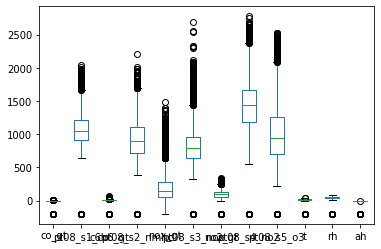

In [10]:
df.plot.box()
#df.plot.box()
# The whiskers extend from the edges of box to show the range of the data. 
# The position of the whiskers is set by default to 1.5*IQR (IQR = Q3 - Q1) from the edges of the box. 
# Outlier points are those past the end of the whiskers.

From the boxplot you can see that all the measurements, especially NOx detected through the multiple sensors, have outliers. Though we may want to actually examine the outliers situation again. 

In [11]:
# sns.set_style('whitegrid')
# eda_data = dfc.drop(['time','rh','ah'], axis=1)
# sns.pairplot(eda_data)

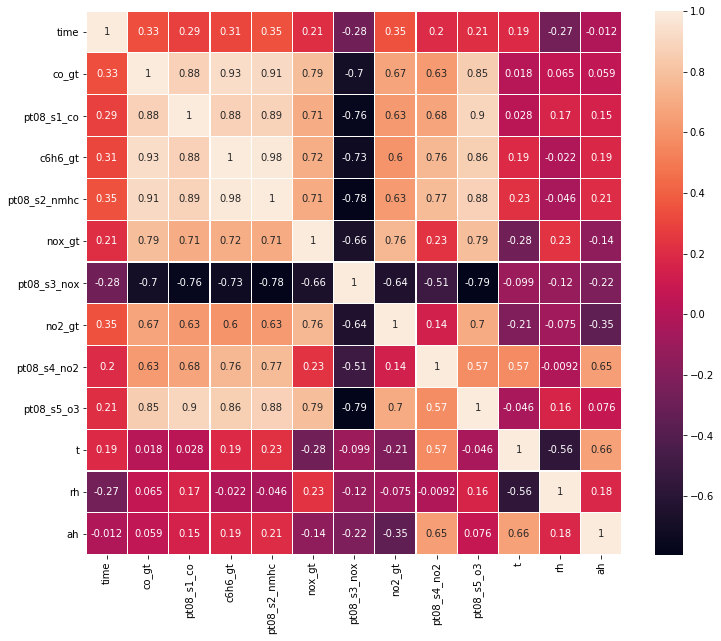

In [12]:
# fig = plt.figure(figsize=(10, 10))
# sns.heatmap(dfc.isnull(),yticklabels=False,cbar=False,cmap='viridis')
# fig.savefig('C:/Users/Christian/Plots/heatmap.png',dpi=150)
fig2=plt.figure(figsize=(12,10))
corr = dfc.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
#f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True,linewidths=0.20)
#fig2.savefig('C:/Users/Christian/Plots/heatcorr.png',dpi=150)

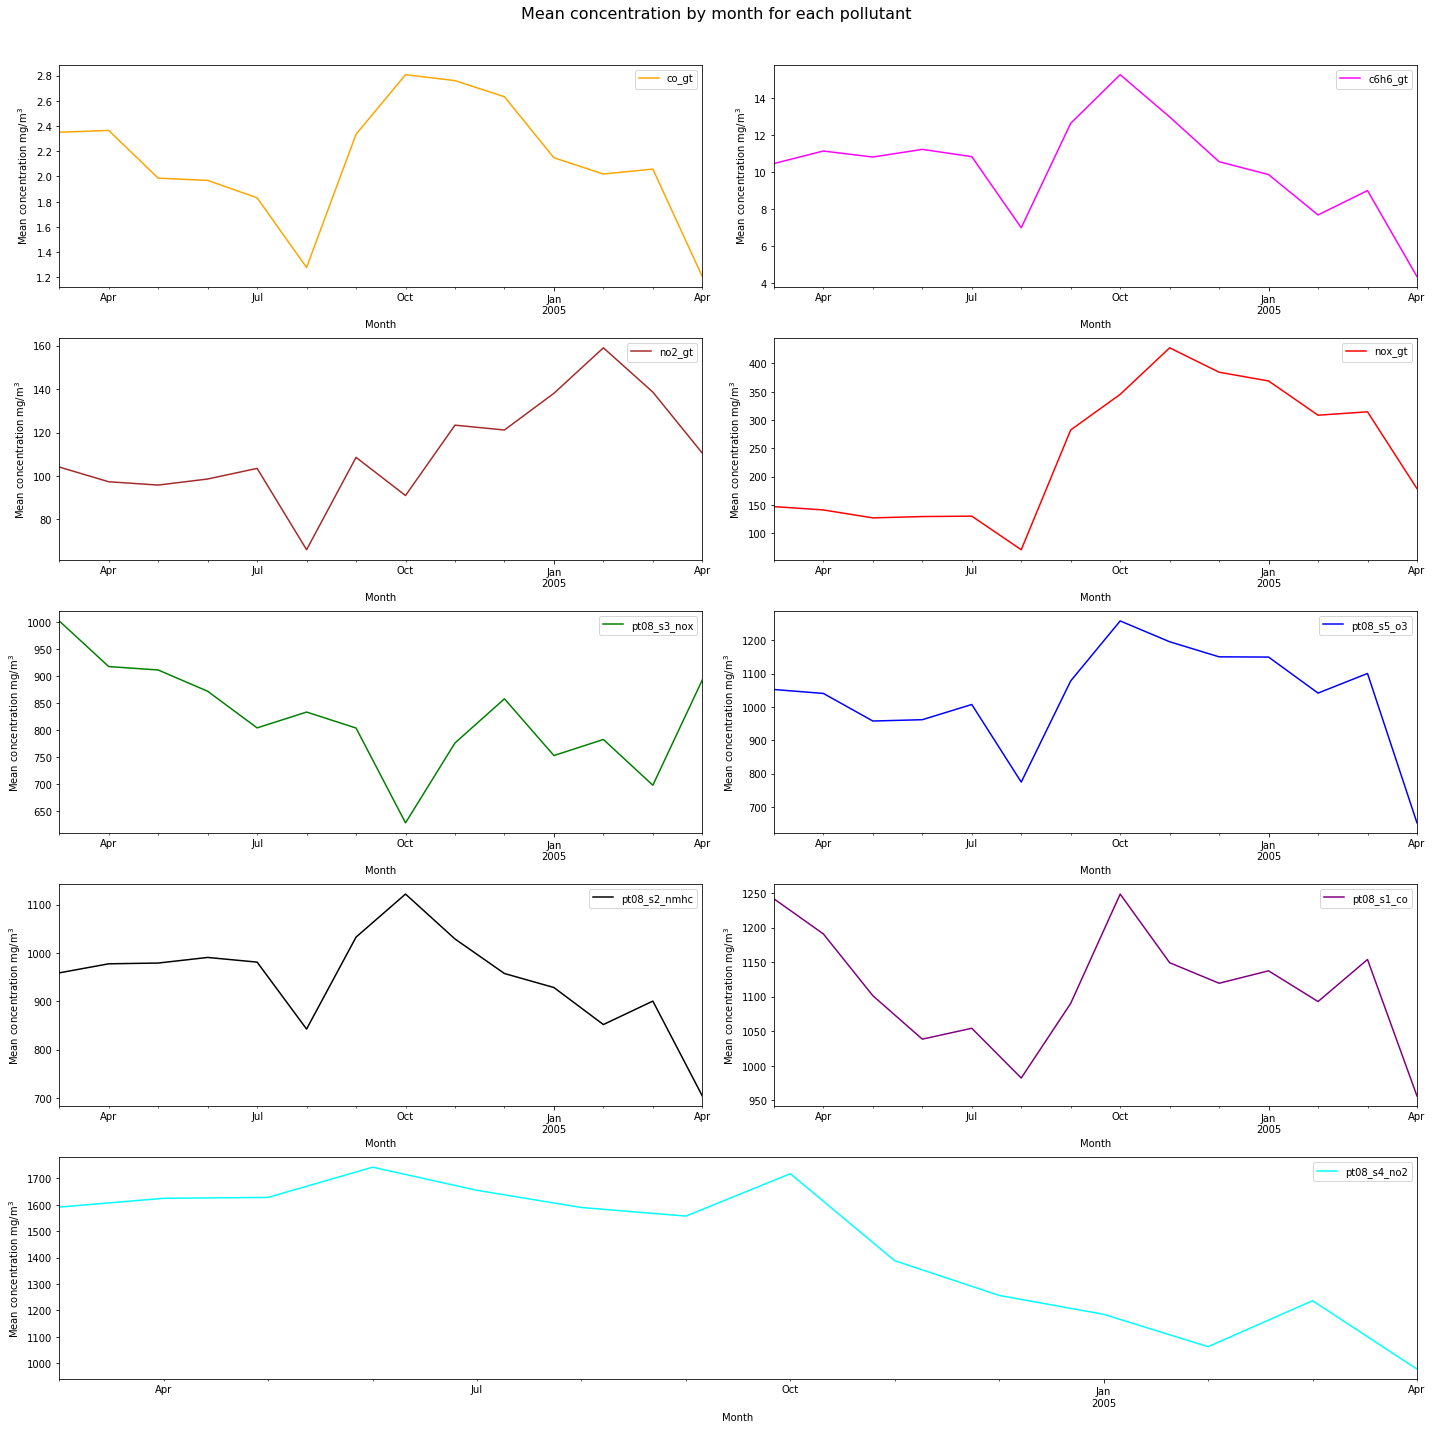

In [13]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(5, 2, 1)
ax2 = fig.add_subplot(5, 2, 2)
ax3 = fig.add_subplot(5, 2, 3)
ax4 = fig.add_subplot(5, 2, 4)
ax5 = fig.add_subplot(5, 2, 5)
ax6 = fig.add_subplot(5, 2, 6)
ax7 = fig.add_subplot(5, 2, 7)
ax8 = fig.add_subplot(5, 2, 8)
ax9 = fig.add_subplot(5, 1, 5)
plt1=dfc[['co_gt','date']].resample('M',on='date').mean().plot(figsize = (20,20),ax=ax1,color='orange')
plt2=dfc[['no2_gt','date']].resample('M',on='date').mean().plot(figsize = (20,20),ax=ax3,color='brown')
plt3=dfc[['nox_gt','date']].resample('M',on='date').mean().plot(figsize = (20,20), ax=ax4,color='red')
plt4=dfc[['c6h6_gt','date']].resample('M',on='date').mean().plot(figsize = (20,20), ax=ax2,color='fuchsia')
plt5=dfc[['pt08_s3_nox','date']].resample('M',on='date').mean().plot(figsize = (20,20), ax=ax5,color='green')
plt6=dfc[['pt08_s5_o3','date']].resample('M',on='date').mean().plot(figsize = (20,20), ax=ax6,color='blue')
plt7=dfc[['pt08_s2_nmhc','date']].resample('M',on='date').mean().plot(figsize = (20,20), ax=ax7,color='black')
plt8=dfc[['pt08_s1_co','date']].resample('M',on='date').mean().plot(figsize = (20,20), ax=ax8,color='purple')
plt9=dfc[['pt08_s4_no2','date']].resample('M',on='date').mean().plot(figsize = (20,20),ax=ax9,color='cyan')
for a in range(1,10):
    plot=locals()["plt"+str(a)] #Non sappiamo davvero perché ma locals() e globals() trasformano stringhe in comandi
    plot.set_xlabel("Month")
    plot.set_ylabel("Mean concentration mg/m$^3$")   
fig.suptitle("Mean concentration by month for each pollutant",fontsize=16,verticalalignment='bottom')    
fig.tight_layout() #This removes extra white space between the figure title and the plots
fig.subplots_adjust(top=0.95) #This makes it so that the title is not juxtaposed to the plots, but has a little bit of distance
plt.show()
#fig.savefig('C:/Users/Christian/Plots/monthdistribution.png',dpi=150)

Text(0.5, 1.0, "All Toxic Gases' Frequency by Month")

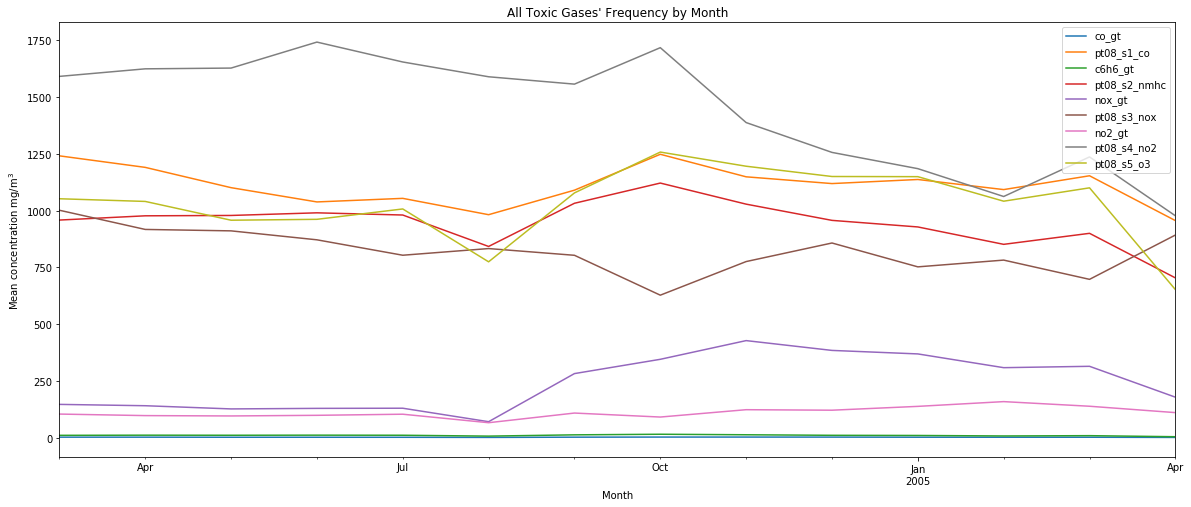

In [14]:
dfc.drop(['t','ah','rh','time'],axis=1).resample('M',on='date').mean().plot(figsize = (20,8))
plt.legend(loc=1)
plt.xlabel('Month')
plt.ylabel('Mean concentration mg/m$^3$')
plt.title("All Toxic Gases' Frequency by Month")

In [15]:
#I consider just the third column, which is a proxy for carbon oxide
df2=df.iloc[:,[0,1,3]]
df2

date      time  pt08_s1_co
0     2004-03-10  18.00.00        1360
1     2004-03-10  19.00.00        1292
2     2004-03-10  20.00.00        1402
3     2004-03-10  21.00.00        1376
4     2004-03-10  22.00.00        1272
...          ...       ...         ...
9352  2005-04-04  10.00.00        1314
9353  2005-04-04  11.00.00        1163
9354  2005-04-04  12.00.00        1142
9355  2005-04-04  13.00.00        1003
9356  2005-04-04  14.00.00        1071

[9357 rows x 3 columns]

I need to check if every day has 24 hours of recordings, so I group by date and check for the column time how many
unique values we have. Within them I single out those that are lower than 24. By printing the entire dataset I see 
that they correspond to the first and the last row

In [16]:
df3 = df2.groupby('date')['time'].nunique()
for i in range(len(df3)):
    if df3[i]<24:
        print(df3[i])
df3

6
15


date
2004-03-10     6
2004-03-11    24
2004-03-12    24
2004-03-13    24
2004-03-14    24
              ..
2005-03-31    24
2005-04-01    24
2005-04-02    24
2005-04-03    24
2005-04-04    15
Name: time, Length: 391, dtype: int64

Eliminating the first day and the last day, since I have to make sure that all days have 24 hours entries

In [17]:
df24h=df2[(df2.date!='2004-03-10') & (df2.date!='2005-04-04')]
df24h

date      time  pt08_s1_co
6     2004-03-11  00.00.00        1185
7     2004-03-11  01.00.00        1136
8     2004-03-11  02.00.00        1094
9     2004-03-11  03.00.00        1010
10    2004-03-11  04.00.00        1011
...          ...       ...         ...
9337  2005-04-03  19.00.00        1248
9338  2005-04-03  20.00.00        1180
9339  2005-04-03  21.00.00        1102
9340  2005-04-03  22.00.00        1116
9341  2005-04-03  23.00.00        1100

[9336 rows x 3 columns]

##  <span style="color:green"> Missing values removal </span>

### Elimination of records with too many missing values

We go on trying to single out missing values. We first select the rows where the value of pt08 corresponds to -200, that signals the missing value. Then, grouping by dates, we count how many rows within the date are missing the value of pt08. We display just the dates that contain missing values. 

In [18]:
df1 = ((df24h['pt08_s1_co']==-200)
        .groupby([df['date']])
        .sum() #you sum all the times within the selected date
        .astype(int) #you display the sum as an integer
        .reset_index(name='count')) #instead of showing 'time' as an index, you show 'count' as an index

#displaying df1 here would show you the count for every considered date, but you want to single out the dates where there
#are missing values in the hours
dfnan=df1[(df1.all(1))] 
dfnan

date  count
21   2004-04-01      3
28   2004-04-08      1
29   2004-04-09     23
75   2004-05-25      5
76   2004-05-26      9
100  2004-06-19     10
101  2004-06-20     24
102  2004-06-21      4
142  2004-07-31      1
151  2004-08-09      4
168  2004-08-26     18
169  2004-08-27     24
170  2004-08-28      3
180  2004-09-07      1
181  2004-09-08     17
204  2004-10-01      1
278  2004-12-14      7
279  2004-12-15     24
280  2004-12-16     24
281  2004-12-17     20
288  2004-12-24      5
297  2005-01-02      3
298  2005-01-03     24
299  2005-01-04     24
300  2005-01-05      1
323  2005-01-28      7
324  2005-01-29      2
334  2005-02-08      7
335  2005-02-09     24
336  2005-02-10     24
337  2005-02-11     21
365  2005-03-11      1

How does .all() work?

In [19]:
#The way .all() works is that it checks if everything is nonzero. all(0), which is the same as all() checks for each column
#all rows and returns the columns for which all rows are nonzero. 

#df1.all()

In [20]:
#You can use this as a mask to select the columns with no zeros. If zero=missing value it's a useful way to see which
#features have no missing values

#df1[df1.columns[df1.all()]]

In [21]:
#With df.all(1) you check all the rows for which all the columns are nonzero, so it's a different kind of selection
#it's the selection we used above

#df1.all(1)

In [22]:
listanan=dfnan[dfnan['count']>12]['count']
listanan
#The number of dates that must be erased is 13 and can be calculated through len(listanan).
#We see that when it's higher than 50%, it's significantly higher

29     23
101    24
168    18
169    24
181    17
279    24
280    24
281    20
298    24
299    24
335    24
336    24
337    21
Name: count, dtype: int32

In [23]:
listanan=dfnan[dfnan['count']>12]['date']
listanan
#These are the dates that need to be eliminated

29     2004-04-09
101    2004-06-20
168    2004-08-26
169    2004-08-27
181    2004-09-08
279    2004-12-15
280    2004-12-16
281    2004-12-17
298    2005-01-03
299    2005-01-04
335    2005-02-09
336    2005-02-10
337    2005-02-11
Name: date, dtype: object

In [24]:
#We eliminate the dates that have too many missing values
df24h_almostclean = df24h[~df24h['date'].isin(listanan)]
len(df24h_almostclean.groupby('date'))

376

In [25]:
df24h_almostclean

date      time  pt08_s1_co
6     2004-03-11  00.00.00        1185
7     2004-03-11  01.00.00        1136
8     2004-03-11  02.00.00        1094
9     2004-03-11  03.00.00        1010
10    2004-03-11  04.00.00        1011
...          ...       ...         ...
9337  2005-04-03  19.00.00        1248
9338  2005-04-03  20.00.00        1180
9339  2005-04-03  21.00.00        1102
9340  2005-04-03  22.00.00        1116
9341  2005-04-03  23.00.00        1100

[9024 rows x 3 columns]

### Handling missing values

In [26]:
dfonlymissing=df24h_almostclean[df24h_almostclean['pt08_s1_co']==-200]
date,time,missing=dfonlymissing.sort_values(['date','time']).to_numpy().T
np.unique(date,True)

(array(['2004-04-01', '2004-04-08', '2004-05-25', '2004-05-26',
        '2004-06-19', '2004-06-21', '2004-07-31', '2004-08-09',
        '2004-08-28', '2004-09-07', '2004-10-01', '2004-12-14',
        '2004-12-24', '2005-01-02', '2005-01-05', '2005-01-28',
        '2005-01-29', '2005-02-08', '2005-03-11'], dtype=object),
 array([ 0,  3,  4,  9, 18, 28, 32, 33, 37, 40, 41, 42, 49, 54, 57, 58, 65,
        67, 74], dtype=int64))

In [27]:
#Here you select the subset with only missing values. You do it by putting between brackets an expression that tells you
#when a certain equivalence is true. In this case you look at when the pollution concentration is -200, meaning missing
#this is because you start from df24h_almostclean where 
dfonlymissing=df24h_almostclean[df24h_almostclean['pt08_s1_co']==-200]

#sort_values orders the values according to the column that you indicate. You can indicate more than one column
#to_numpy() translates it from pandas to an np array, so then you have an array of arrays. Each array contains a row
#.T transposes the array, so you'll have an array containing three arrays, where each array is a column
#this last operation allows you to have all the different features separated in different arrays
#indeed, you save them like this, by mentioning three different variables
date,time,missing=dfonlymissing.sort_values(['date','time']).to_numpy().T

#np.unique saves only one value from each group of equal values. Setting the second argument to True allows you to
#save also the index where this value is found. This is useful when you actually have ordered the dates
udates,index=np.unique(date,True)

#You use the indexes you saved to split the array in subarrays. The indexes indicate the points where the operations
#needs to cut the array in subarrays
#Now you have a list of all the hours that are missing for each date
arrays=np.split(time,index[1:])

#What you want is to try and see if these dates are all consecutive, thus you create a function
def checkifconsecutive(lista):
    n=len(lista)-1
    if n==0:
        #if the list has only one element then you equal True
        return True
    else:
        #if the list has more than one element you check
        #np.diff computes subsequent difference in the whole array for each element. 
        #If they are consecutive the difference should be 1
        #you then sum all of them and check if the sum is equal to the length of the array-1. 
        #If not they are not consecutive
        return sum(np.diff(sorted(lista)))==n

for a in arrays: #for each array we convert the hours in integers, otherwise the function won't work
    i=0
    for i in range(len(a)):
        a[i]=int(a[i][0:2])

#arrays contains only the times, already split. So you actually convert them into lists and append them in the right column
#you do the same to checkifconsecutive. Apparently the two "for" are synchronous
dfalmostclean1 = ((df24h_almostclean['pt08_s1_co']==-200)
        .groupby([df['date']])
        .sum()
        .astype(int)
        .reset_index(name='count'))
dfnan1=dfalmostclean1[(dfalmostclean1.all(1))]

dfnew=pd.DataFrame({'date':udates,'time':[list(a) for a in arrays],'consecutive': [checkifconsecutive(a) for a in arrays],'count':dfnan1['count']})
dfnew

#THIS IS FOR TESTING IF THE PROCEDURE WORKS. WITH DEEPCOPY YOU ACTUALLY CREATE A COPY AND NOT A REFERENCE
#YOU MANIPULATE THE ARRAYS TO REMOVE SOME OF THE HOURS AND CHECK IF YOUR FUNCTION ACTUALLY DETECTS THE FACT THAT 
#THERE ARE HOURS THAT ARE NOT CONSECUTIVE

# arraystest=copy.deepcopy(arrays)
# mask=np.ones(len(arraystest[2]),dtype=bool)
# mask[[3]]=False
# arraystest[2]=arraystest[2][mask]
# mask=np.ones(len(arraystest[3]),dtype=bool)
# mask[[3]]=False
# arraystest[3]=arraystest[3][mask]
# arraystest
# arrayscopy=copy.deepcopy(arraystest)
# def checkifconsecutive(lista):
#     n=len(lista)-1
#     if n==0:
#         return True
#     else:
#         return sum(np.diff(sorted(lista)))==n
# for a in arrayscopy:
#     i=0
#     for i in range(len(a)):
#         a[i]=int(a[i][0:2])
# dfnew=pd.DataFrame({'date':udates,'time':[list(a) for a in arraystest],'consecutive': [checkifconsecutive(a) for a in arrayscopy]})
# dfnew

date                                      time  consecutive  count
21   2004-04-01                              [14, 15, 16]         True      3
28   2004-04-08                                      [23]         True      1
74   2004-05-25                      [19, 20, 21, 22, 23]         True      5
75   2004-05-26               [0, 1, 2, 3, 4, 5, 6, 7, 8]         True      9
99   2004-06-19  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]         True     10
100  2004-06-21                              [0, 1, 2, 3]         True      4
140  2004-07-31                                       [0]         True      1
149  2004-08-09                          [16, 17, 18, 19]         True      4
166  2004-08-28                                 [0, 1, 2]         True      3
176  2004-09-07                                      [23]         True      1
199  2004-10-01                                      [14]         True      1
273  2004-12-14              [17, 18, 19, 20, 21, 22, 23]         True      7
280  2004-12-24                      [19, 20, 21, 22, 23]         True      5
289  2005-01-02                              [21, 22, 23]         True      3
290  2005-01-05                                       [0]         True      1
313  2005-01-28              [17, 18, 19, 20, 21, 22, 23]         True      7
314  2005-01-29                                    [0, 1]         True      2
324  2005-02-08              [17, 18, 19, 20, 21, 22, 23]         True      7
352  2005-03-11                                      [11]         True      1

In [28]:
lista45=[]
for i in dfnew['time']:
    for a in i:
        lista45.append(a)
pd.Series(lista45).value_counts()

23    9
19    7
21    7
22    7
0     6
20    6
18    5
17    5
1     4
16    3
14    3
2     3
15    2
3     2
8     1
7     1
6     1
5     1
4     1
11    1
dtype: int64

At this point we want to substitute the missing values in the time series that we can save for future analysis. A method we can deploy is finding the time series that most resemble the one we are trying to complete and then consider them in order to substitute the value we are missing. More specifically, we can consider as similar time series that have a shape that is close to the targeted one. In order to do that, we should normalize the whole dataset in order not to account for the fact that a similar time series may be translated on the vertical axis and so be recognized as different. Moreover, we should also account for the fact that similar time series may be horizontally shifted. In order to do that, for each time series in the dataset, we generate other time series that are shifted of one and two time-slots forward and backwards. This assuming that a time shift higher than 2 hours will not be too common. Moreover we want to avoid having a peak at noon being considered similar to a peak at 8pm. 
The way we normalize the time series is by subtracting to each time series its average value so to bring it to 0 and judge its shape. Normalizing the whole dataset would not serve our scope since it would still keep the vertical shift between time series. 

In [29]:
test=df24h[df24h['date']=='2004-03-11'] 
#You need to use this formulation because the operation inside of the parenthesis gives you a mask
#meaning it runs through the whole dataset and assigns "true" or "false" to the boolean expression you put within the 
#brackets. 
#I need to understand how to scale this down
test

date      time  pt08_s1_co
6   2004-03-11  00.00.00        1185
7   2004-03-11  01.00.00        1136
8   2004-03-11  02.00.00        1094
9   2004-03-11  03.00.00        1010
10  2004-03-11  04.00.00        1011
11  2004-03-11  05.00.00        1066
12  2004-03-11  06.00.00        1052
13  2004-03-11  07.00.00        1144
14  2004-03-11  08.00.00        1333
15  2004-03-11  09.00.00        1351
16  2004-03-11  10.00.00        1233
17  2004-03-11  11.00.00        1179
18  2004-03-11  12.00.00        1236
19  2004-03-11  13.00.00        1286
20  2004-03-11  14.00.00        1371
21  2004-03-11  15.00.00        1310
22  2004-03-11  16.00.00        1292
23  2004-03-11  17.00.00        1383
24  2004-03-11  18.00.00        1581
25  2004-03-11  19.00.00        1776
26  2004-03-11  20.00.00        1640
27  2004-03-11  21.00.00        1313
28  2004-03-11  22.00.00         965
29  2004-03-11  23.00.00         913

In [30]:
values=test['pt08_s1_co'].values.reshape(len(test['pt08_s1_co']),1) 
#remember that .values returns an numpy array representation of the df series 
#reshape takes the data you have in your array and gives it a different shape - the arguments are nr of rows and nr of
#columns. In order to apply StandardScaler we need to feed it an array of arrays. Meaning a matrix with one value for
#each row, since it will take it as a different value like this. 
values

array([[1185],
       [1136],
       [1094],
       [1010],
       [1011],
       [1066],
       [1052],
       [1144],
       [1333],
       [1351],
       [1233],
       [1179],
       [1236],
       [1286],
       [1371],
       [1310],
       [1292],
       [1383],
       [1581],
       [1776],
       [1640],
       [1313],
       [ 965],
       [ 913]], dtype=int64)

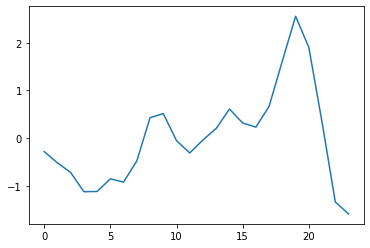

In [31]:
values=test['pt08_s1_co'].values.reshape(len(test['pt08_s1_co']),1) 
scaler=skpre.StandardScaler().fit_transform(values)

# StandardScaler is the scaler that calculates the mean and the standard deviation and rescales the values accordingly
# It is sensitive to the presence of outliers.
# Normally if you are standardizing with some values missing the result you'll get is that 
# the interval where the new values lie will be narrower than the interval you get 
# when standardizing with all no values missing. 
# That is why we will test it to see the differences between what happens with StandardScaler and RobustScaler
# which is provided as an alternative by scikitlearn preprocessing. 

# fit calculates the sample mean and the standard deviation whereas transform does the transformation on the array
# Now we want to visualize the result, in order to do that we need to get back to something we can turn into a pd.series
# We have rows with just one value each. What we do here now is say we want one row with 24 values, since 24 is the length
# of the column of co detection. 

#scaler.shape

# you understand how many axes you have and how many values per axes. The result will be a tuple which will have length
# equal to the dimension of the array and a value contained in each spot that tells you how many value each dimension
# hosts. 

scaler2=scaler.reshape(len(test['pt08_s1_co']))

# .reshape() is a method that allows you to modify the shape towards what you desire. In this case we want 1 dimension
# with 24 values. Obviously all values should find a new home so you need to account for all the value you have in the 
# n-dimensional array when you are trying to reshape. The argument of reshape is a tuple that shows the new shape of the
# array, in terms of dimensions and values for each dimension

forplot=pd.Series(scaler2) #convert to series in order to plot it
forplot.plot()

In [32]:
#test['pt08_s1_co'].plot(color='orange')
# values=test['pt08_s1_co'].values.reshape(len(test['pt08_s1_co']),1) 
# scaler=skpre.RobustScaler().fit_transform(values)
# scaler2=scaler.reshape(len(test['pt08_s1_co']))
# forplot=pd.Series(scaler2) #convert to series in order to plot it
# forplot.plot()

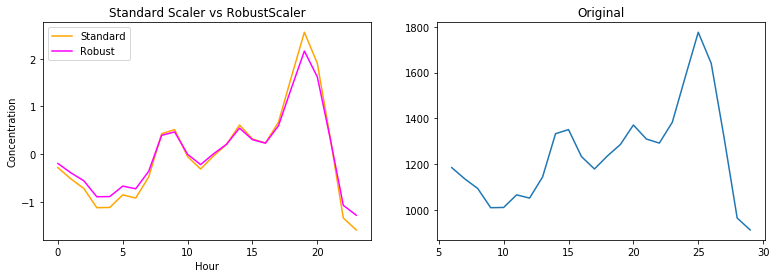

In [33]:
#Let's try and compare the standard scaler with the robust scaler with the original shape
#Create the figures
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
#Plot the standardscaler
plt1=forplot.plot(figsize = (20,4),ax=ax1,color='orange')
plt1.set_title('StandardScaler')
#Plot the RobustScaler
values2=test['pt08_s1_co'].values.reshape(len(test['pt08_s1_co']),1) #Reshape into 2-dimensional array
scalerRobust=skpre.RobustScaler().fit_transform(values) #Fit the scaler
scaler2Robust=scalerRobust.reshape(len(test['pt08_s1_co'])) #Go back to 1-dimensional array
forplotRobust=pd.Series(scaler2Robust) #convert to series in order to plot it
plt2=forplotRobust.plot(figsize = (20,4),ax=ax1,color='fuchsia')
plt2.set_title("Standard Scaler vs RobustScaler")
ax1.legend(['Standard','Robust'])
#plt1.legend(handles=[plt1,plt2],['Standard','Robust'])
#Plot the original series
plt3=test['pt08_s1_co'].plot(figsize = (20,4), ax=ax2)
plt3.set_title("Original")
#Set titles for axes
for a in range(1,3):
    plot=locals()['plt'+str(a)]
    plot.set_xlabel('Hour')
    plot.set_ylabel('Concentration')

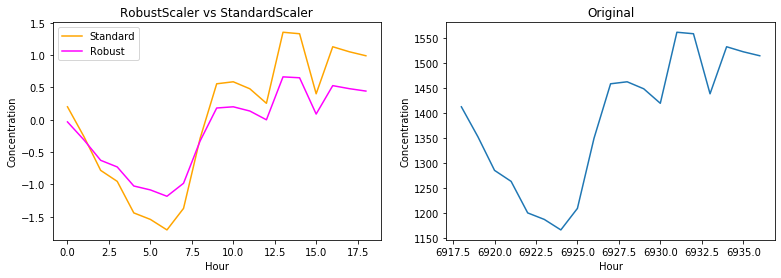

In [34]:
#Let's observe the behaviour with a time series that is missing some values
testNaN=df24h[df24h['date']=='2004-12-24'] 
testNaN=testNaN.replace(-200,np.nan)
#Training the StandardScaler
valuesNaN=testNaN['pt08_s1_co'].values.reshape(len(testNaN['pt08_s1_co']),1) 
scalerNaN=skpre.StandardScaler().fit_transform(valuesNaN)
scaler2NaN=scalerNaN.reshape(len(test['pt08_s1_co']))
forplotNaN=pd.Series(scaler2NaN)
#Let's try and compare the standard scaler with the robust scaler with the original shape
#Create the figures
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
#Plot the standardscaler
plt1=forplotNaN.plot(figsize = (20,4),ax=ax1,color='orange')
#Plot the RobustScaler
values2NaN=testNaN['pt08_s1_co'].values.reshape(len(testNaN['pt08_s1_co']),1) #Reshape into 2-dimensional array
scalerRobustNaN=skpre.RobustScaler().fit_transform(values2NaN) #Fit the scaler
scaler2RobustNaN=scalerRobustNaN.reshape(len(testNaN['pt08_s1_co'])) #Go back to 1-dimensional array
forplotRobustNaN=pd.Series(scaler2RobustNaN) #convert to series in order to plot it
plt2=forplotRobustNaN.plot(figsize = (20,4),ax=ax1,color='fuchsia')
plt2.set_title("RobustScaler vs StandardScaler")
#Plot the original series
plt3=testNaN['pt08_s1_co'].plot(figsize = (20,4), ax=ax2)
plt3.set_title("Original")
#Set titles for axes
ax1.legend(['Standard','Robust'])
for a in range(1,4):
    plot=locals()['plt'+str(a)]
    plot.set_xlabel('Hour')
    plot.set_ylabel('Concentration')

In [35]:
#Let's scale the whole dataset with StandardScaler
#Copy the dataset so that you can scale it
dfscale=copy.deepcopy(df24h_almostclean)
#Substitute the -200 to NaN
dfscale=dfscale.replace(-200,np.nan)
#For each time series you need to reshape, scale, reshape and put back in the dataframe
grouped=dfscale['pt08_s1_co'].groupby(dfscale['date'])
#grouped.describe()

#Since we cannot directly modify the df we want to generate a new dataframe with the values that we get from scaling
#First we generate a new dataframe with the right columns

dfscale2=pd.DataFrame({'date':[],'time':[],'pt08_s1_co':[]}) #Generate the new dataframe

# grouped here is a tuple, since it has the data organized like (date) which we call "name" and then (all the values) which
# we call "group". Imagine a structure as such ([(cat,(2,3)),(dog,(5,6)),(mouse,(8,9))]). 
# So you have grouped by animals, and then you have all the values that pertain to that animal belonging to the other
# dataframe categories. So when you want to iterate, you need to consider both the name AND the group, meaning you
# take out cat and (2,3) first then dog and (5,6) and so on. If the categories were more, you would have needed to add
# another variable after the for in order to correctly unpack everything. You see a proper example below this cell

for name,group in grouped: 
    values=group.values.reshape(len(test['pt08_s1_co']),1) #transform the column in a 2-dimensional array
    scaler=skpre.StandardScaler().fit_transform(values) #in order to fit the Standard Scaler
    group=pd.Series(scaler.reshape(len(test['pt08_s1_co']))) #then you reshape it back into a series
    num=0
    for i in group: #for each value in the group, meaning for each scaled value of pt08
        rowdf=pd.DataFrame([[name,num,i]], columns=['date','time','pt08_s1_co']) #you create a new row for the value
        dfscale2=dfscale2.append(rowdf, ignore_index=True) #that has the date, which you regulate with the first for
        num+=1 #the scaled value which you regulate with this second for and an hour you regulate with a count
dfscale2

date  time  pt08_s1_co
0     2004-03-11   0.0   -0.284438
1     2004-03-11   1.0   -0.520000
2     2004-03-11   2.0   -0.721911
3     2004-03-11   3.0   -1.125732
4     2004-03-11   4.0   -1.120925
...          ...   ...         ...
9019  2005-04-03  19.0    2.597988
9020  2005-04-03  20.0    1.935398
9021  2005-04-03  21.0    1.175367
9022  2005-04-03  22.0    1.311783
9023  2005-04-03  23.0    1.155879

[9024 rows x 3 columns]

In [36]:
#EXAMPLE TO UNPACK A TUPLE

# t=([(1,(2,3)),(4,(5,6)),(7,(8,9))])
# for x,y in t:
#     print(x)
#     print(y)
#     print('---')

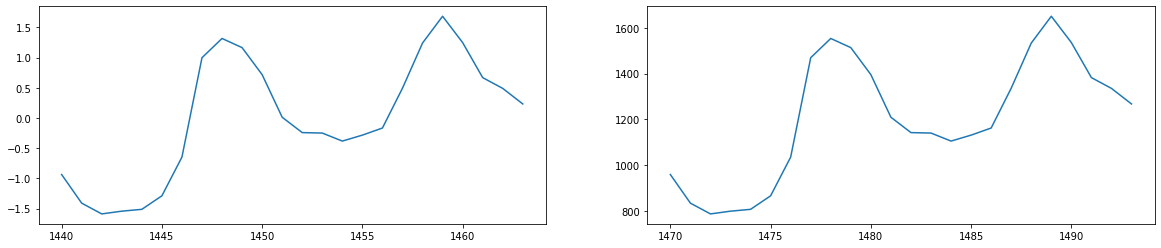

In [37]:
#Plot a few series to verify that the scaling happened
fig=plt.figure(figsize=(20,4))
ax10=fig.add_subplot(1,2,1)
ax20=fig.add_subplot(1,2,2)
dfscale2['pt08_s1_co'][dfscale2['date']=='2004-05-11'].plot(ax=ax10)
dfscale['pt08_s1_co'][dfscale['date']=='2004-05-11'].plot(ax=ax20)

In this section we are adding columns to the dataset with some categorical variables (Months, Weeks, Day of the week) that can be useful to derive explanatory images. We will also derive a dummy variable from the variation of mean pollution among days. If from one day to another the mean increases we will print 1, otherwise we will print -1. Thus, in the correspondence of the day where the decrease is registered, there will be a -1. This aids the graphical representation of the following fact: weekends contribute substantially to the depollution of the city

In [38]:
#Copy the dataset so that you can scale it
dfscale=copy.deepcopy(df24h_almostclean)
#Substitute the -200 to NaN
dfscale=dfscale.replace(-200,np.nan)


dfscale['time'] = pd.to_datetime(dfscale['time'],format= '%H.%M.%S').dt.hour
dfscale['date'] = pd.to_datetime(dfscale['date'])

def dayweek(row):
    return row['date'].weekday()
def month(row):
    return row['date'].month
def nrweek(row):
    return row['date'].week

#through df.apply you apply a function to all the rows or columns - with axis=1 you apply it to all the rows
#lambda denotes an anonymous function, that in this case contains another function
#it works by doing lambda (what you give): (what is returned, so the application of the function)

dfscale['day of week'] = dfscale.apply (lambda row: dayweek(row), axis=1)
dfscale['week']=dfscale.apply(lambda row: nrweek(row),axis=1)
dfscale['Month']=dfscale.apply(lambda row: month(row), axis=1)

# #You can use .loc to access things inside of a dataframe based on their label name 
# #indexslice is a command that allows you to "skip" the first layer of a multi-index dataframe, considering the following
# #selection as valid for all the different column labels
# plotselect=grouped3.loc[:,pd.IndexSlice[:,'mean']]

groupedx=dfscale.groupby(dfscale['date'])
tableau2=groupedx.describe()

def increasedecrease(i):
    if pd.isnull(i):
        return 0
    if i<0:
        return -1
    else:
        return 1

difference_pollutants_mean=tableau2.loc[:,('pt08_s1_co','mean')].diff()
#tableau2.loc[:,('pt08_s1_co','diff')]=series.apply(increasedecrease)

#To execute only when you want to save the excel to generate graphs on Tableau.

# tableau2.to_excel('C:/Users/Christian/Desktop/Università/DATA SCIENCE/DA DARE/3. DM II/uci-air-quality/uci-air-quality/data/tableau4.xlsx')
tableau2



time                                               pt08_s1_co  \
           count  mean       std  min   25%   50%    75%   max      count   
date                                                                        
2004-03-11  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2004-03-12  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2004-03-13  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2004-03-14  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2004-03-15  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
...          ...   ...       ...  ...   ...   ...    ...   ...        ...   
2005-03-30  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2005-03-31  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2005-04-01  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2005-04-02  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   
2005-04-03  24.0  11.5  7.071068  0.0  5.75  11.5  17.25  23.0       24.0   

                         ...  week       Month                                \
                   mean  ...   75%   max count mean  std  min  25%  50%  75%   
date                     ...                                                   
2004-03-11  1244.166667  ...  11.0  11.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
2004-03-12  1281.666667  ...  11.0  11.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
2004-03-13  1330.666667  ...  11.0  11.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
2004-03-14  1361.125000  ...  11.0  11.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
2004-03-15  1452.166667  ...  12.0  12.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
...                 ...  ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
2005-03-30  1106.000000  ...  13.0  13.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
2005-03-31  1008.125000  ...  13.0  13.0  24.0  3.0  0.0  3.0  3.0  3.0  3.0   
2005-04-01   903.291667  ...  13.0  13.0  24.0  4.0  0.0  4.0  4.0  4.0  4.0   
2005-04-02   890.958333  ...  13.0  13.0  24.0  4.0  0.0  4.0  4.0  4.0  4.0   
2005-04-03   981.375000  ...  13.0  13.0  24.0  4.0  0.0  4.0  4.0  4.0  4.0   

                 
            max  
date             
2004-03-11  3.0  
2004-03-12  3.0  
2004-03-13  3.0  
2004-03-14  3.0  
2004-03-15  3.0  
...         ...  
2005-03-30  3.0  
2005-03-31  3.0  
2005-04-01  4.0  
2005-04-02  4.0  
2005-04-03  4.0  

[376 rows x 40 columns]

You can use .loc to access things inside of a df based on their label name. Plus, there is Indexslice that allows you to skip the first layer of a multi-index df, considering the following selection as valid for all the different column labels

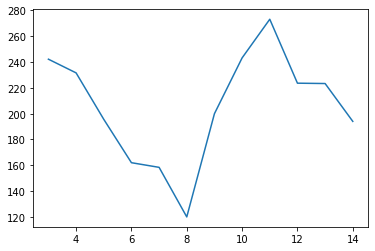

In [39]:
plotselect=tableau2.loc[:,pd.IndexSlice[:,'mean']]
proveu=dfscale[:8208].groupby('Month').describe()['pt08_s1_co']
proveu.index=[13,14,3,4,5,6,7,8,9,10,11,12]
# proveu.index[1]=14
proveu1=proveu[2:]
proveu2=proveu[:2]
proveu1.append(proveu2)['std'].plot()

## Substituting missing values - part 3: finding the pool of similar time series

##  <span style="color:fuchsia"> A little parenthesis on NaN values. </span>

NaN stands for Not A Number and is a common missing data representation. It is a special floating-point value and cannot be converted to any other type than float. None and NaN sound similar, look similar but are actually quite different. None is a Python internal type which can be considered as the equivalent of NULL. The None keyword is used to define a null value, or no value at all. None is not the same as 0, False, or an empty string. It is a datatype of its own (NoneType) and only None can be … None. While missing values are NaN in numerical arrays, they are None in object arrays.

### nan is NOT equal to nan
At first, reading that np.nan == np.nan is False can trigger a reaction of confusion and frustration. Let’s imagine that instead of nan values, we are looking at a group of people that we do not know. They are completely unknown people to us. Unknown people can be seen as all the same to us, meaning that we describe them all as unknown. However, in reality, it does not mean that one unknown person is equal to another unknown person.
To leave this strange metaphor of mine and go back to Python, NaN cannot be equal to itself because NaN is the result of a failure, but that failure can happen in multiple ways. The result of one failure cannot be equal to the result of any other failure and unknown values cannot be equal to each other.

### Equality vs Identity
Now, to understand why np.nan in [np.nan] is True, we have to look at the difference between equality and identity.

### Equality

Equality refers to the concept that most Python programmers know as “==”. This is used to ask Python whether the content of the variable is the same as the content of another variable.
num = 1
num2 = 1
num == num2 
The last line will result inTrue . The content of both variables is the same. As I said previously, the content of NaN is never equal to the content of another NaN.

### Identity

Identity is when you are asking Python if a variable is the same as another variable, meaning you are asking Python whether the two variables share the same identity. Python assigns an id to each variable that is created, and ids are compared when Python looks at the identity of a variable in an operation. However, np.nan is a single object that always has the same id, no matter which variable you assign it to.
import numpy as np
one = np.nan
two = np.nan
one is two
np.nan is np.nan is True and one is two is also True.
If you check the id of one and two using id(one) and id(two) , the same id will be displayed.
np.nan in [np.nan] is True because the list container in Python checks identity before checking equality. However, there are different “flavors”of nans depending on how they are created. float(‘nan’) creates different objects with different ids so float('nan') is float('nan') actually gives False!! We will mention these differences again later.

### Testing if a value is nan
As I said, whenever you want to know if a value is a nan, you cannot check whether it is equal to nan. However, there are many other options to do so and the one I propose are not the only ones available out there.
```
import numpy as np
import pandas as pd
var = float('nan')
var is np.nan results in True
```
or
```
np.isnan(var) results in True
```
or
```
pd.isna(var) results in True
```
or
```
pd.isnull(var) results in True
```
pd.isnull & pd.isna() behave identically. Pandas provide the .isnull() function as it is an adaptation of R dataframes in Python. In R, null and na are two different types with different behaviours.

### For Dataframes
```
import pandas as pd
df = pd.DataFrame(some_data)
df.dropna()
```
will drop all rows of your dataset with nan values. 
use the subset parameter to drop rows with nan values in specific columns
will drop all rows of your dataset with nan values. 
`df.fillna()`
will fill nan values with the value of your choice
`df.isnull()`
same as pd.isnull() for dataframes
`df.isna()`
same as `pd.isna()` for dataframes

In order to color different sections of the line in different ways you need to select different segments. Remember you want to color a line according to a third variable, so you will select three variables from your dataset. These variables will constitute a 3 dimensional matrix. You are going to take the x and the y that you desire and put them in an array like 

## Parenthesis on how to create segments (for plots or for other purposes)

In [40]:
#Let's create a two dimensional array

# x = np.linspace(0, 500, 501)
# y = np.sin(x)
# np.array([x, y])

You will thus have a row with all the x values and a row with all the y values. In order to have the actual points stacked you need to transpose

In [41]:
# np.array([x, y]).T

Now we want to create segments. In order to create the segments we need to create a three dimensional array, like so

In [42]:
# points=np.array([x, y]).T.reshape(-1,1,2) #-1 means the rows will be as many as the ones contained in the previous matrix
# points

The way you read this is you consider the first parenthesis, which is the rows. Every comma represents an extension of the dimension, meaning you consider another row, then another, then another. This implies that the matrix height gets extended. The second parenthesis has no comma, meaning that there is only one dimension (as requested). This means that the width of the matrix is of just one cell, you don't extend it. The third parenthesis has one comma, meaning that in depth you have two cells to consider. 
Afterwards you use the command concatenate to put together two points into a segment. 

In [43]:
# a=[[1,2,3,4]]
# an=np.array(a)
# b=[[10,20,30,40]]
# bn=np.array(b)
# np.concatenate([an,bn],axis=0)


#This is the command to concatenate the two arrays, if you don't specify the axis
#it does it horizontally. If you specify axis=1 you do it vertically


In [44]:
# a=[[1],[2],[3],[4],[5]]

# #This gives you the entire array without the last element

# a[:-1]

In [45]:
#This gives you the entire array without the first element

# a=[[1],[2],[3],[4],[5]]
# a[1:]

If you want to concatenate

In [46]:
# a=[[1],[2],[3],[4],[5]]
# a[:-1]
# np.concatenate([a[:-1],a[1:]], axis=1)

## Finding the similar time series

In order to fill the missing values we find, for each time series, the 5 most similar ones. Once we do that, we select the point in time that we want to substitute and we take as reference the other 5, which we will use to create a distribution. From this distribution we will randomly pick a value, in order to keep the variability intact. 

In [47]:
#Let's import the dtw library as d
import dtw as d
# #Let's single out all time series with missing values and drop the missing values, so that we can warp the time series
# #with all the other time series in the datasets and select a subset of timeseries that is sufficiently similar
# saveprova=dfscale2[dfscale2['date']=='2004-04-01'].dropna()['pt08_s1_co']
# saveprova

In [48]:
#del dfscale[dfscale2['date']=='2004-03-11']

dnomissing=dfscale2
for i in dfnew.date.index:
    dnomissing=dnomissing[dnomissing['date'] != dfnew.date[i]]


In [49]:
dwnm=dfscale
for i in dfnew.date.index:
    dwnm=dwnm[dwnm['date'] != dfnew.date[i]]
dwnm

date  time  pt08_s1_co  day of week  week  Month
6    2004-03-11     0      1185.0            3    11      3
7    2004-03-11     1      1136.0            3    11      3
8    2004-03-11     2      1094.0            3    11      3
9    2004-03-11     3      1010.0            3    11      3
10   2004-03-11     4      1011.0            3    11      3
...         ...   ...         ...          ...   ...    ...
9337 2005-04-03    19      1248.0            6    13      4
9338 2005-04-03    20      1180.0            6    13      4
9339 2005-04-03    21      1102.0            6    13      4
9340 2005-04-03    22      1116.0            6    13      4
9341 2005-04-03    23      1100.0            6    13      4

[8568 rows x 6 columns]

In [50]:
#We select here all the dates, considering just the emissions, that we use to find the nearest ones with respect to the
#dynamic time warping function
dates=dnomissing['date']
dicdates={}
for i in dates:
    dicdates[i]=list(dnomissing[dnomissing['date']==i]['pt08_s1_co'])    
dicdates


{'2004-03-11': [-0.28443768814302905,
  -0.5200001679009176,
  -0.7219108648362507,
  -1.1257322587069167,
  -1.1209248611608373,
  -0.8565179961264727,
  -0.9238215617715837,
  -0.48154098753228275,
  0.42705714867671596,
  0.5135903045061444,
  -0.053682605931219866,
  -0.3132820734195052,
  -0.039260413292981786,
  0.20110946401098612,
  0.6097382554277315,
  0.3164870051168907,
  0.22995384928746226,
  0.6674270259806838,
  1.6192917401043967,
  2.5567342615898716,
  1.902928195323079,
  0.3309091977551288,
  -1.342065148280488,
  -1.5920498206766145],
 '2004-03-12': [-0.7372810781020367,
  -0.8688948903913258,
  -1.0736274872857756,
  -1.4355654710813208,
  -1.6476099464362868,
  -1.5891149187521583,
  -1.2966397803315157,
  -0.6970657465691984,
  1.1162801116387855,
  0.9627306639679482,
  0.24982251406763192,
  -0.06824419896481687,
  -0.2766327350895247,
  -0.10845953049765522,
  0.019498342561375892,
  0.260790331758406,
  0.09992900562705259,
  -0.02802886743197852,
  0.83477

In [51]:
#prova1=list(dfscale2[dfscale2['date']=='2004-04-01'].dropna()['pt08_s1_co'])
#prova1

In [52]:
#We create this list in order to append the day number to the various time series
listagiorni=[]
for datax in dicdates.keys():
    listagiorni.append(list(dwnm[dwnm['date']==datax]['day of week'].unique())[0])
listagiorni

[3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 4,
 5,
 6,
 0,
 1,
 2,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,


In [53]:
arrays = [np.array(np.repeat(dfnew['date'],5)),
           np.array(np.tile((np.arange(0,5,1)),len(dfnew['date'])))]
arrays
# prod=len(arrays[0])*len(arrays[1])
# prod
# s = pd.Series(np.random.randn(95), index=arrays)
# s
dfser = pd.DataFrame(np.random.randn(95, 3), index=arrays,columns=['date','distance','day of week'])
dfser.head()
#dfser = pd.DataFrame(np.random.randn(prod+1, 3), index=arrays)

date  distance  day of week
2004-04-01 0 -0.788079 -2.021342     2.322884
           1  0.776378  0.700540     1.957621
           2  0.302752 -0.092833     1.348341
           3  0.646674 -0.852222    -1.077009
           4  1.770987 -0.498627     3.406320

In [54]:
missingdate=list(dfscale2[dfscale2['date']=='2004-04-01'].dropna()['pt08_s1_co'])
emissiondate=dicdates['2004-03-11']
d.dtw(missingdate,emissiondate).distance

16.789209841951564

In [55]:
#prova2=dicdates['2004-04-01']
for day in dfnew['date']: #For each day in the dataframe of dates with missing values
    missingdate=list(dfscale2[dfscale2['date']==day].dropna()['pt08_s1_co'])
    listadic=[]
    for emissionday in dicdates.values(): 
        a=d.dtw(missingdate,emissionday).distance
        listadic.append(a)
        #list(dicdates.keys())[list(dicdates.values()).index(i)]
    dfdtw=pd.DataFrame({'date':[b for b in dicdates.keys()],'distance':listadic,'day of week':listagiorni})
    dfdtw=dfdtw.sort_values(by='distance')[0:5]
    dfdtwindex=dfdtw.set_index(np.arange(0,5,1))
    for i in range(0,5):
        for j in dfdtw:
            dfser.loc[(day,i),j]=dfdtwindex.loc[i,j]
dfser           

date  distance  day of week
2004-04-01 0  2004-11-09  5.821057          1.0
           1  2005-03-17  6.978901          3.0
           2  2005-03-09  7.681605          2.0
           3  2005-03-21  7.789488          0.0
           4  2004-07-14  7.817505          2.0
...                  ...       ...          ...
2005-03-11 0  2004-06-10  6.328454          3.0
           1  2004-11-23  6.716717          1.0
           2  2004-04-23  6.774185          4.0
           3  2005-03-18  6.978190          4.0
           4  2005-02-03  7.099318          3.0

[95 rows x 3 columns]

In [56]:
for i in dfser.loc[('2004-06-21')][['date']].values:
     print(i.item())


2004-04-20
2004-07-20
2004-07-14
2004-05-03
2004-11-16


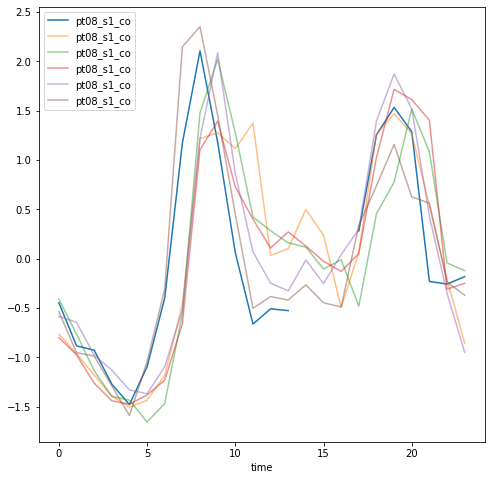

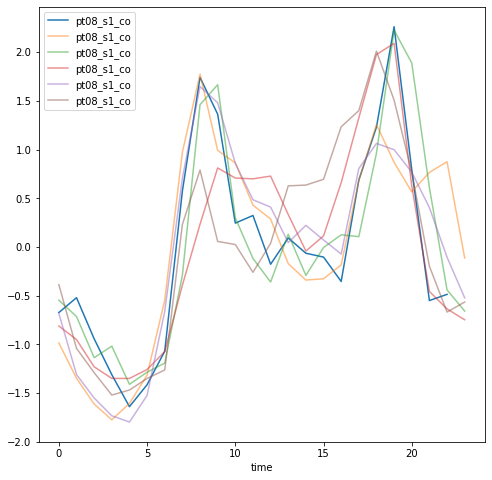

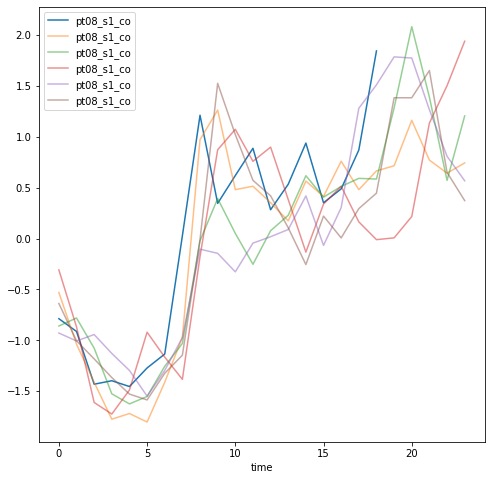

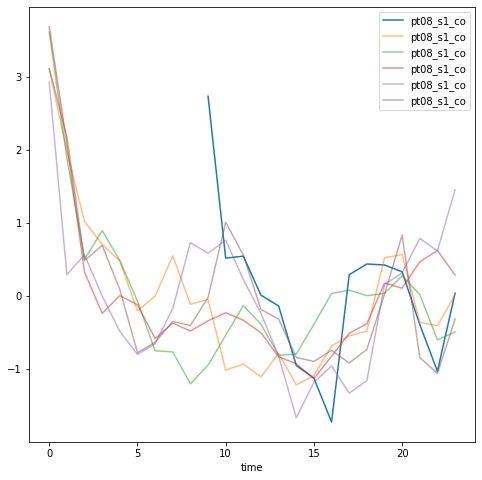

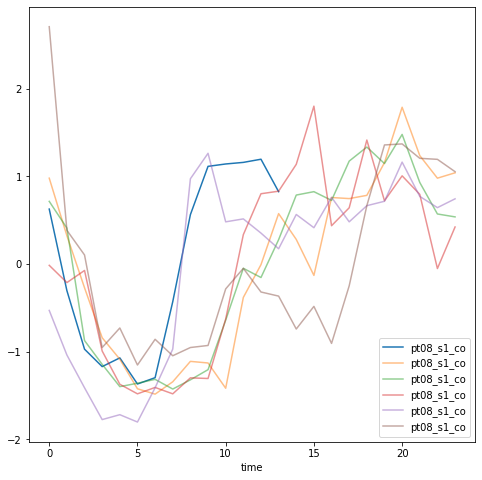

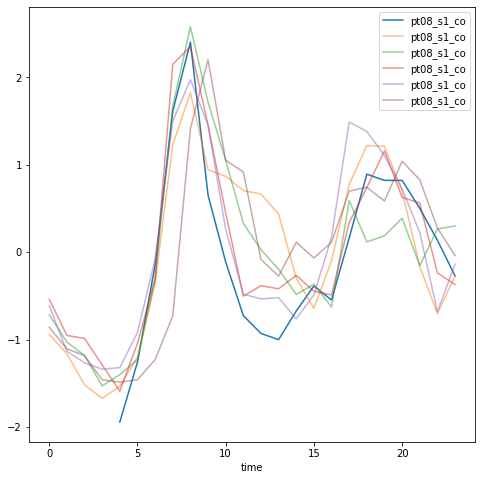

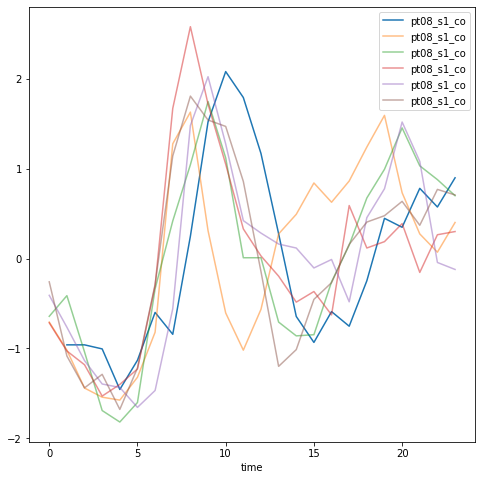

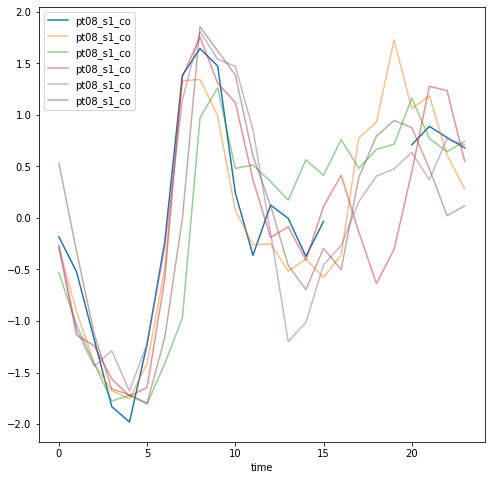

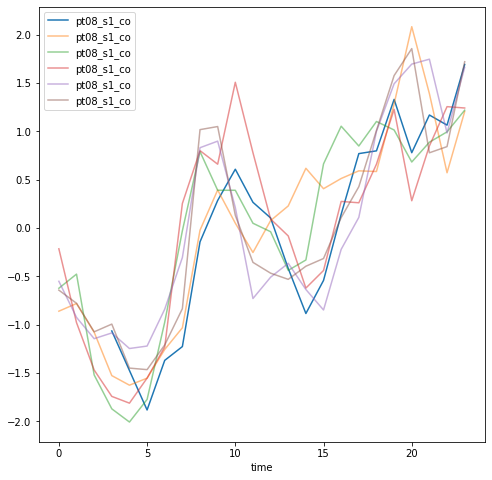

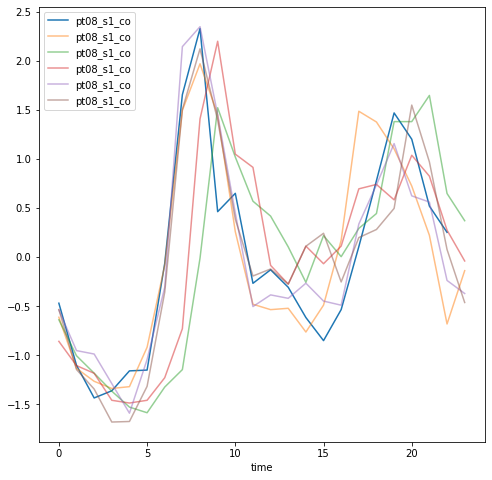

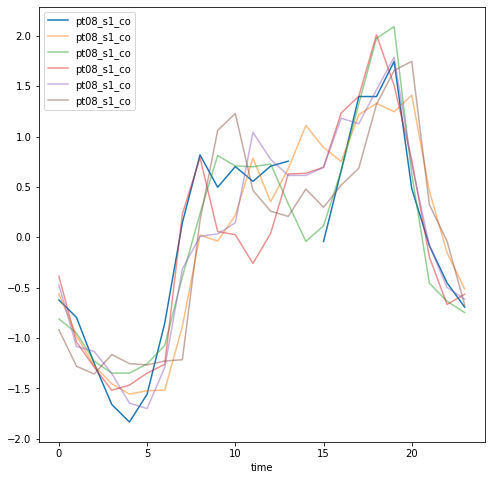

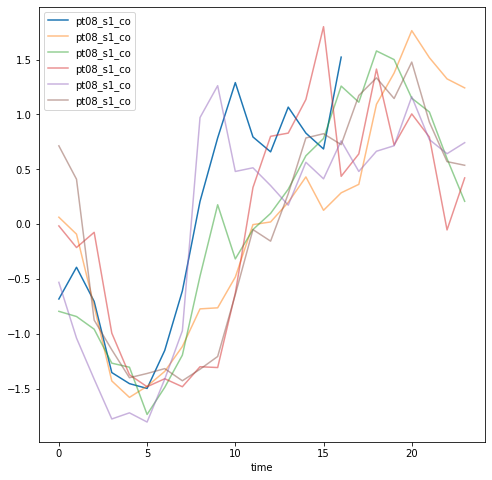

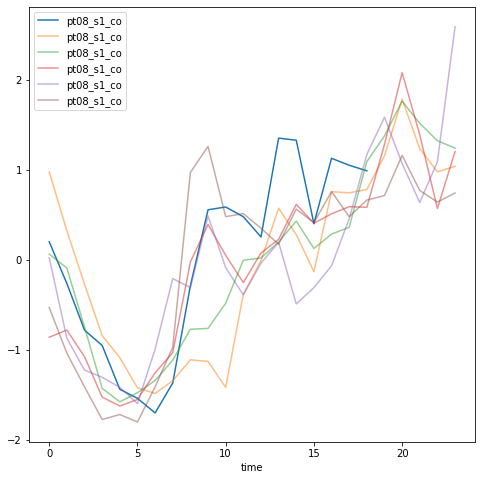

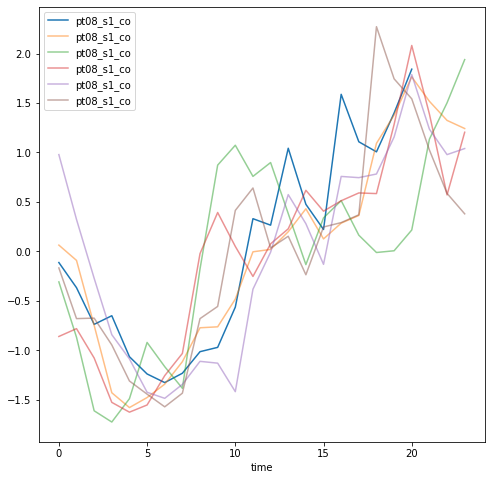

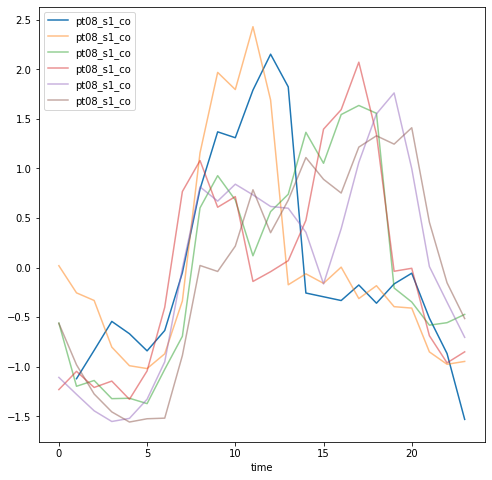

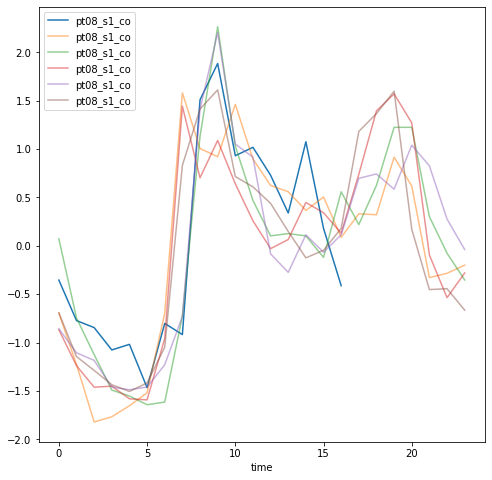

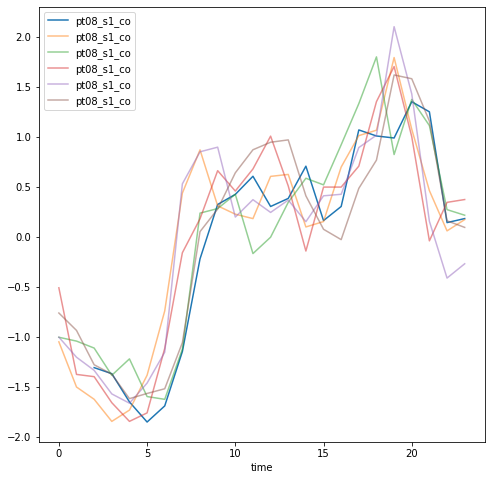

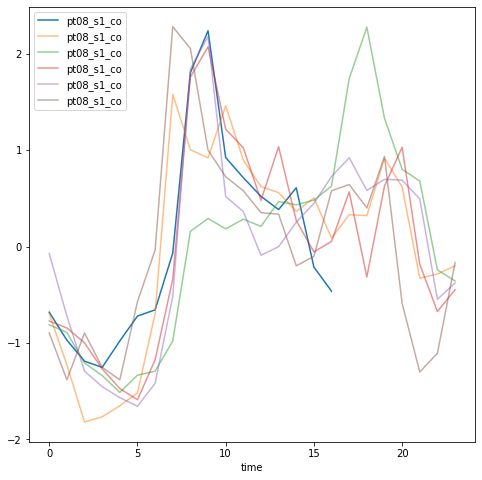

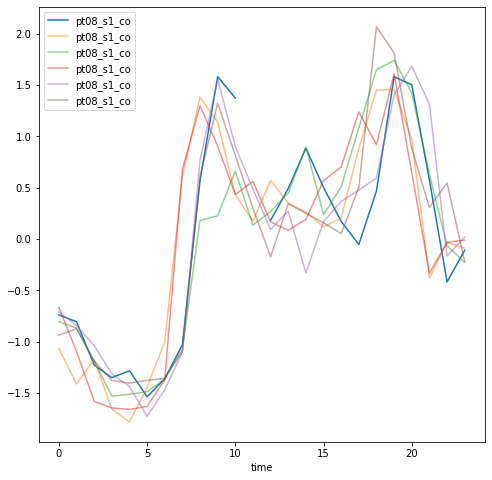

In [57]:
for day in dfnew['date']:
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(1, 1, 1)
    #Abbiamo bisogno di un dataset senza differenza su asse x solo per i plot
    dfscale2[dfscale2['date']==day].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax1)
    for matchingday in dfser.loc[(day)][['date']].values:
        dfscale2[dfscale2['date']==matchingday.item()].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax1,alpha=0.5)
    plt.show()    

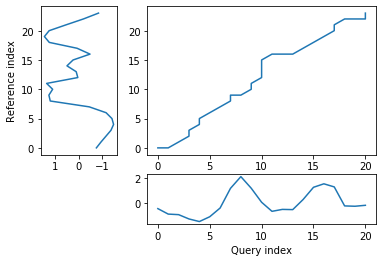

In [58]:
missingdate=list(dfscale2[dfscale2['date']=='2004-04-01'].dropna()['pt08_s1_co'])
emissiondate=dicdates['2004-11-09']
plotx=d.dtw(missingdate,emissiondate,)
d.dtwPlotThreeWay(plotx,missingdate,emissiondate)


In [59]:
#(query, reference) = d.dtw_test_data.sin_cos()

In [60]:
# plt.plot(reference)
# plt.plot(query)

In [61]:
# alignment = d.dtw(query,reference,keep_internals=True)

In [62]:
# len(query)

In [63]:
# alignment.index1

In [64]:
# alignment.index2

In [65]:
# listaalign=[]
# for i in range(len(alignment.index1)):
#     listaalign.append((alignment.index1[i],alignment.index2[i]))

In [66]:
# listaalign

In [67]:
# d.dtwPlotTwoWay(alignment)

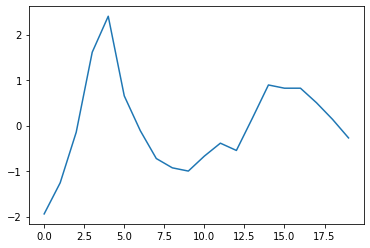

In [68]:
missingdate=list(dfscale2[dfscale2['date']=='2004-06-21'].dropna()['pt08_s1_co'])
plt.plot(missingdate)

In [69]:
# emissiondate

In [70]:
emissiondate=dicdates['2004-04-20']
arremission=[]
for i in range(1,25):
    arremission.append([])
    for j in range(i):
        arremission[i-1].insert(0,emissiondate[len(emissiondate)-1-j])
arremission

[[-0.27279663552890926],
 [-0.7039913174939594, -0.27279663552890926],
 [-0.1627979921704781, -0.7039913174939594, -0.27279663552890926],
 [0.6995913717596222,
  -0.1627979921704781,
  -0.7039913174939594,
  -0.27279663552890926],
 [1.2099850769427427,
  0.6995913717596222,
  -0.1627979921704781,
  -0.7039913174939594,
  -0.27279663552890926],
 [1.2187849684114171,
  1.2099850769427427,
  0.6995913717596222,
  -0.1627979921704781,
  -0.7039913174939594,
  -0.27279663552890926],
 [0.7743904492433553,
  1.2187849684114171,
  1.2099850769427427,
  0.6995913717596222,
  -0.1627979921704781,
  -0.7039913174939594,
  -0.27279663552890926],
 [-0.09679880615541941,
  0.7743904492433553,
  1.2187849684114171,
  1.2099850769427427,
  0.6995913717596222,
  -0.1627979921704781,
  -0.7039913174939594,
  -0.27279663552890926],
 [-0.6423920772132379,
  -0.09679880615541941,
  0.7743904492433553,
  1.2187849684114171,
  1.2099850769427427,
  0.6995913717596222,
  -0.1627979921704781,
  -0.703991317493

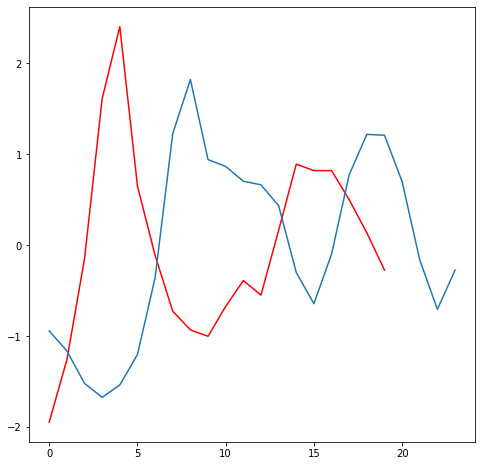

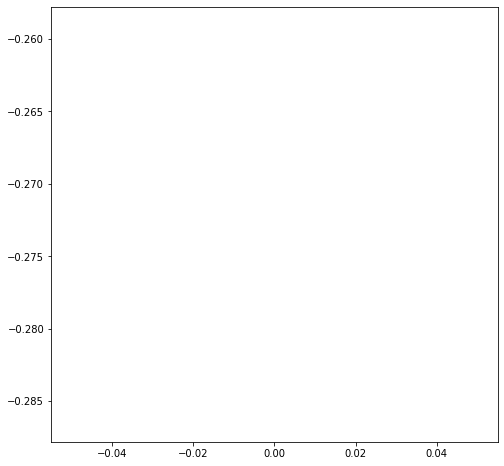

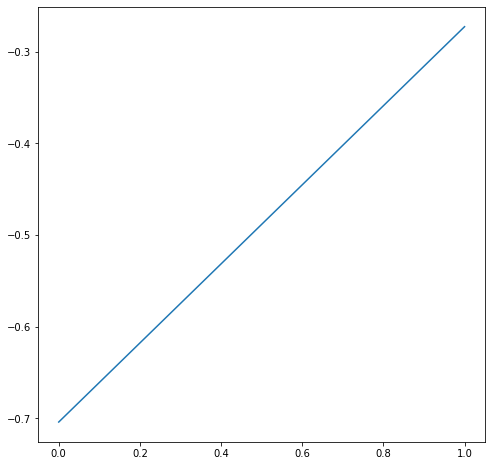

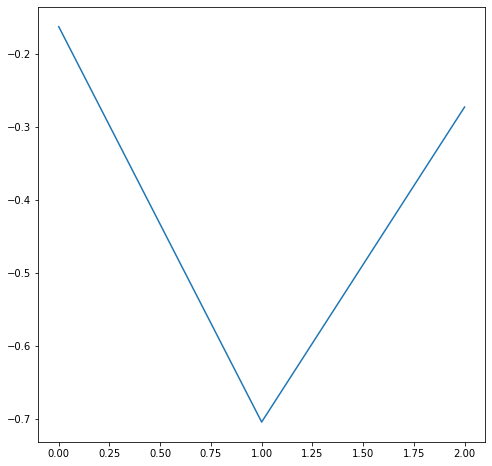

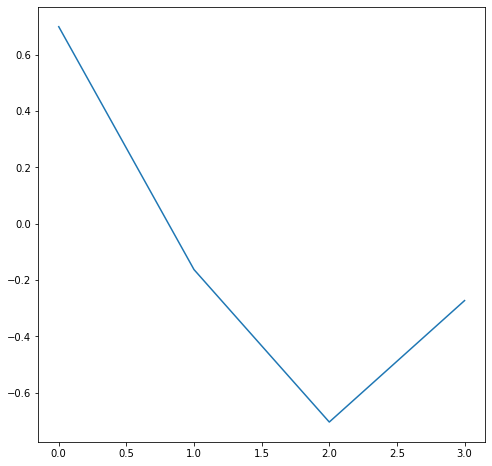

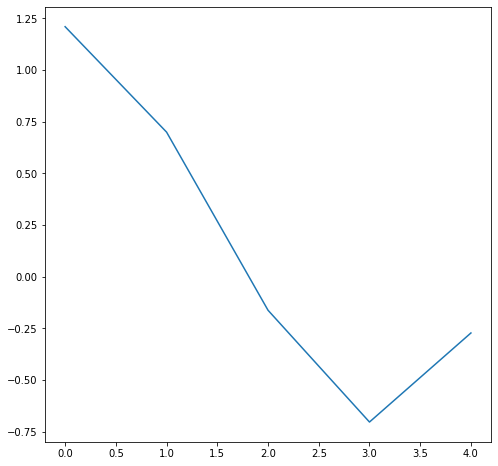

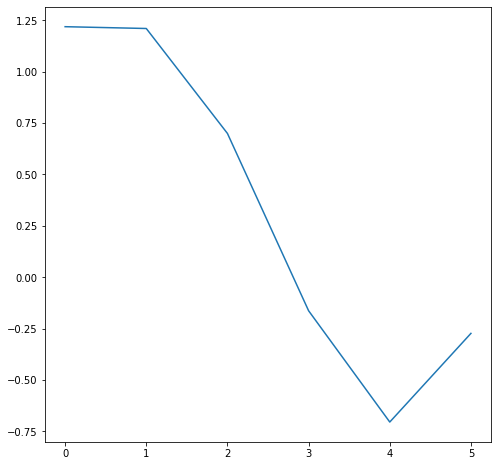

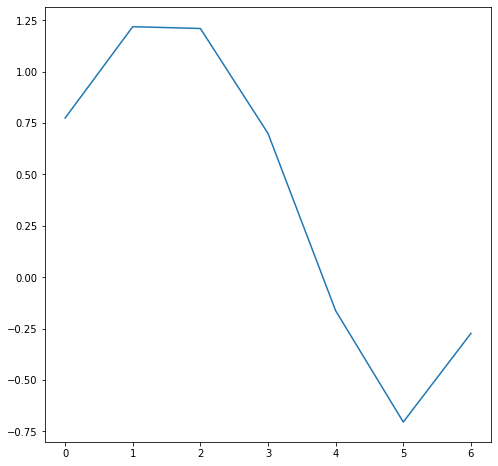

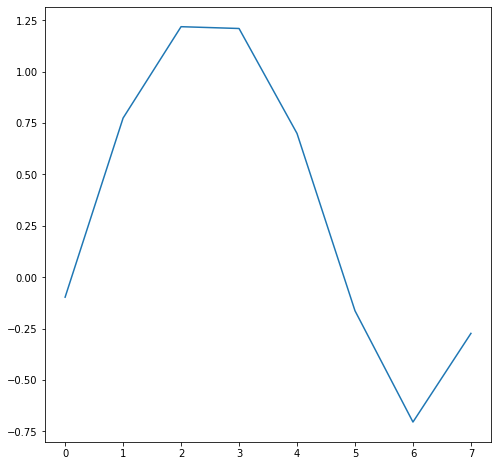

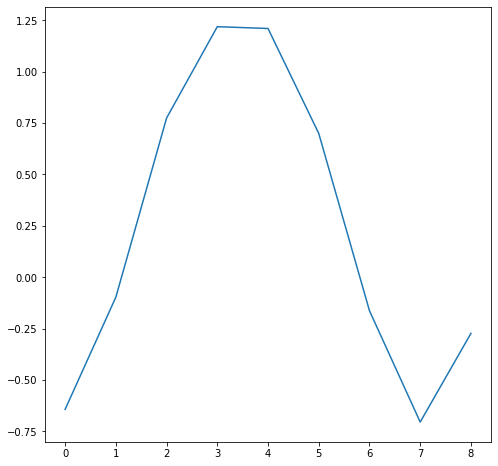

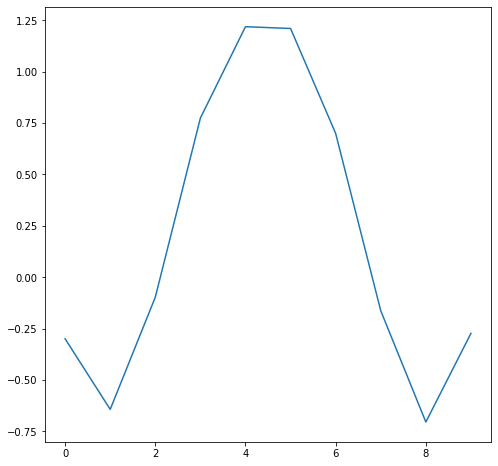

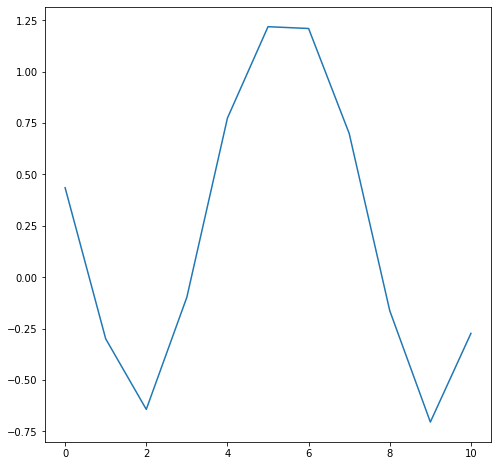

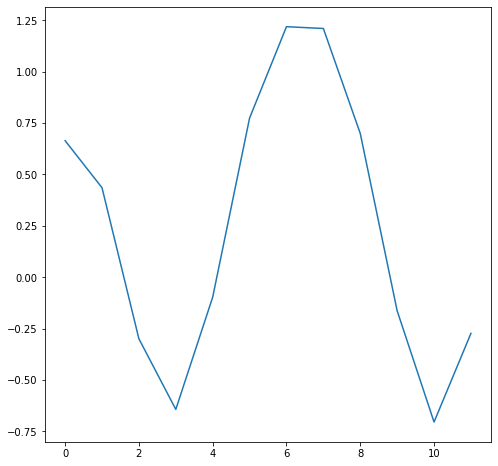

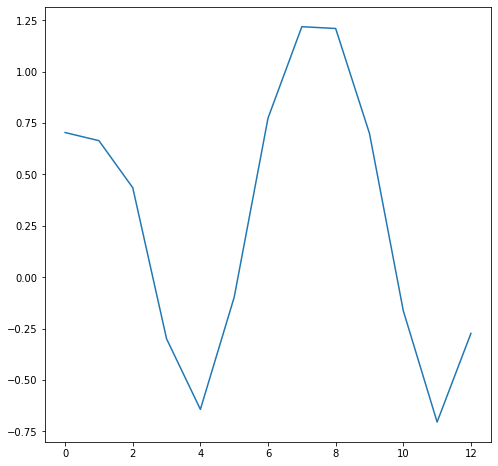

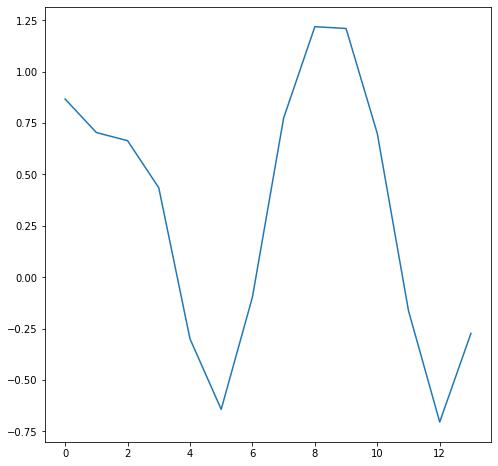

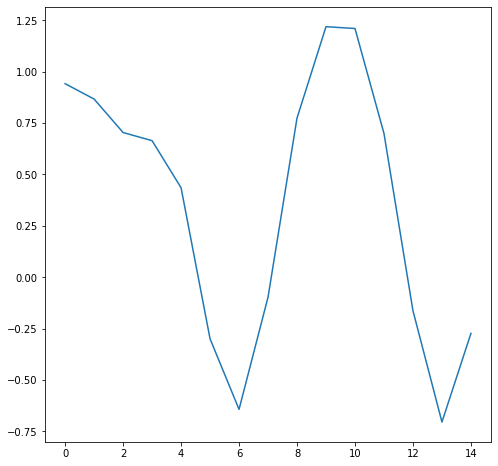

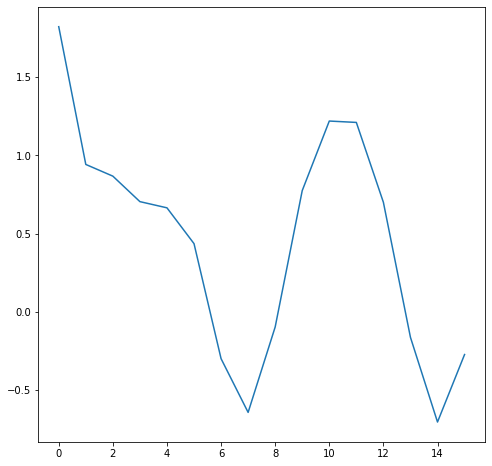

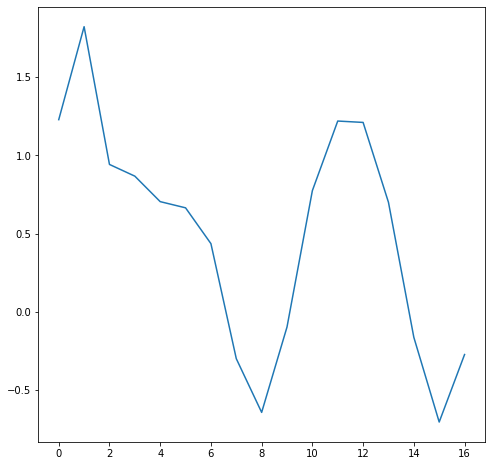

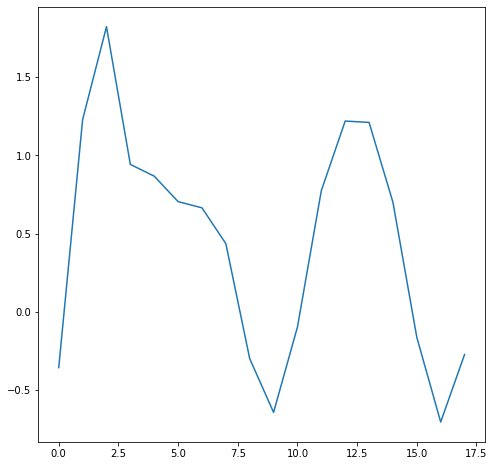

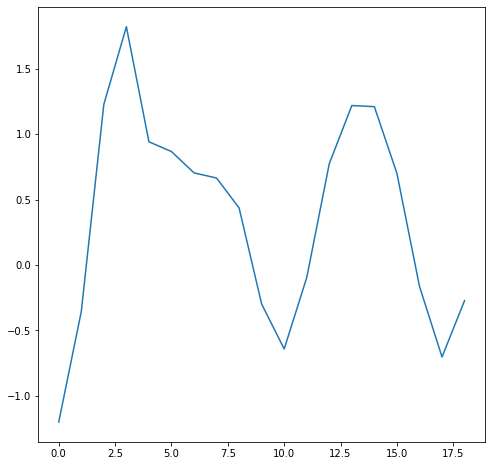

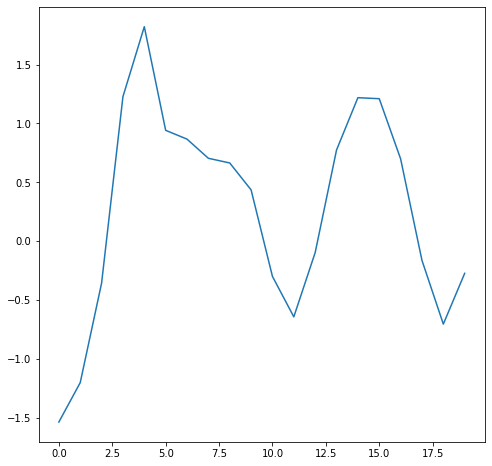

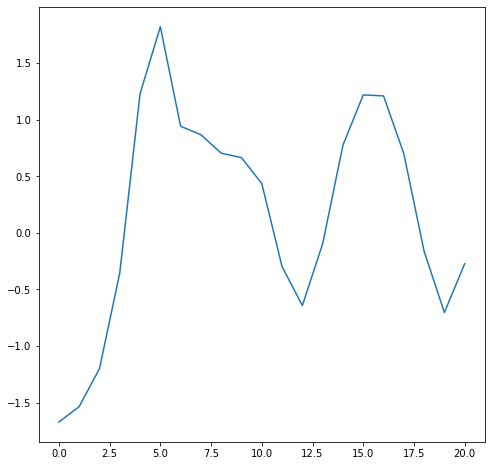

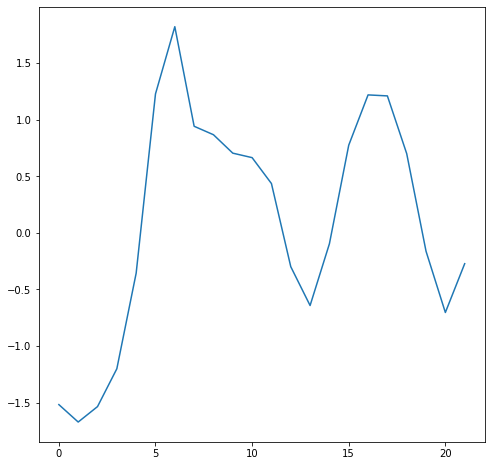

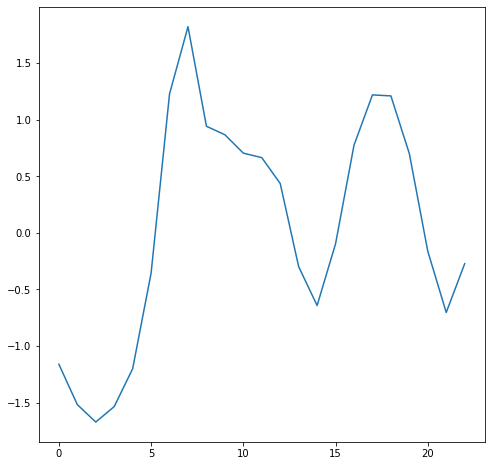

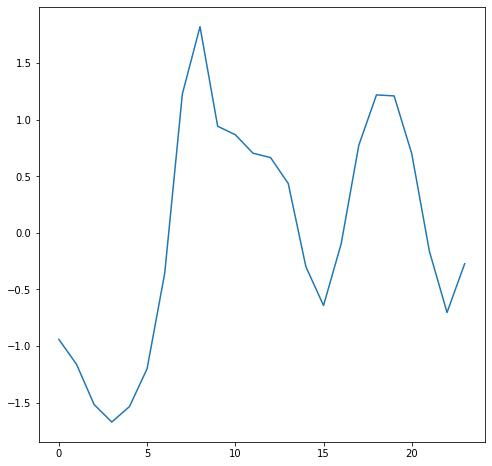

In [71]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1)
pd.Series(missingdate).plot(ax=ax1,color='red')
pd.Series(emissiondate).plot(ax=ax1)
for sequence in arremission:
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(1, 1, 1)
    #Abbiamo bisogno di un dataset senza differenza su asse x solo per i plot
    pd.Series(sequence).plot(ax=ax1)
    plt.show()

In [72]:
indexsplit=arraydtwdistance.index(min(arraydtwdistance))
valuesfordistribution=emissiondate[:len(emissiondate)-indexsplit]
indexsplit

NameError: name 'arraydtwdistance' is not defined

In [73]:
# vettoremma=[]
# for i in arremission:
#     alignment4=d.dtw(missingdate,i,keep_internals=True)
#     vettoremma.append(alignment4.distance)
# indexsplit=vettoremma.index(min(vettoremma))
# print(vettoremma.index(min(vettoremma)))
# print(emissiondate[indexsplit:])

In [74]:
x=np.array(range(len(emissiondate[indexsplit:])))
y=np.array(emissiondate[indexsplit:])
step=5/11
start=0
np.interp(0.45,x,y)

NameError: name 'indexsplit' is not defined

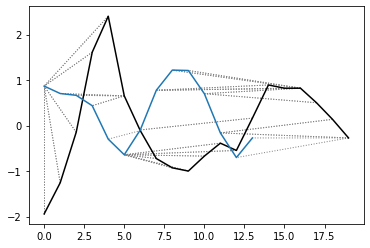

In [75]:
alignmentoptimum=d.dtw(missingdate,arremission[13],keep_internals=True)
d.dtwPlotTwoWay(alignmentoptimum)

In [76]:
alignment2=d.dtw(missingdate,emissiondate,keep_internals=True)

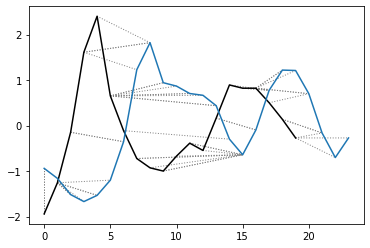

In [77]:
d.dtwPlotTwoWay(alignment2)

In [78]:
listaalign2=[]
for i in range(max(len(alignment2.index1),len(alignment2.index2))):
    listaalign2.append((alignment2.index1[i],alignment2.index2[i]))

In [79]:
listaalign2

[(0, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 6),
 (3, 7),
 (3, 8),
 (4, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (6, 14),
 (7, 15),
 (8, 15),
 (9, 15),
 (10, 15),
 (11, 15),
 (12, 15),
 (13, 16),
 (14, 17),
 (15, 17),
 (16, 17),
 (16, 18),
 (16, 19),
 (16, 20),
 (17, 20),
 (18, 21),
 (19, 21),
 (19, 22),
 (19, 23)]

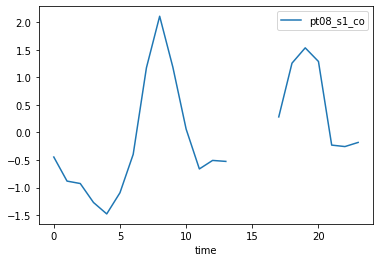

In [80]:
dfscale2[dfscale2['date']=='2004-04-01'].loc[:,['time','pt08_s1_co']].set_index('time').plot()

In [81]:
#Questa la fissi, è parte di un ciclo for più esterno
missingdate=list(dfscale2[dfscale2['date']=='2004-04-01'].dropna()['pt08_s1_co'])

In [82]:
for i in range(5):
    dfser.loc['2004-06-19']['date'].values[i]
    emissiondate=dicdates[dfser.loc['2004-06-19']['date'].values[0]]
    alignment=d.dtw(missingdate,emissiondate,keep_internals=True)
    listaalign=[]
    for i in range(max(len(alignment.index1),len(alignment.index2))):
        listaalign.append((alignment.index1[i],alignment.index2[i]))

In [83]:
listaalign

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 3),
 (2, 3),
 (2, 4),
 (3, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (6, 11),
 (6, 12),
 (7, 13),
 (8, 13),
 (9, 13),
 (10, 14),
 (10, 15),
 (11, 15),
 (12, 15),
 (13, 15),
 (14, 15),
 (14, 16),
 (14, 17),
 (14, 18),
 (15, 19),
 (16, 20),
 (17, 21),
 (17, 22),
 (17, 23),
 (18, 23),
 (19, 23),
 (20, 23)]

In [84]:
emissiondate=dicdates[dfser.loc['2004-04-01']['date'].values[0]]

In [85]:
dfnew.loc[(dfnew['date']=='2004-04-01'),'time'].iloc[0][len(dfnew.loc[(dfnew['date']=='2004-04-01'),'time'].iloc[0])-1]

16

In [86]:
dfscale3=copy.deepcopy(dfscale2)

In [87]:
for i in range(len(dfnew)):
    date=dfnew['date'].iloc[i]
    print("Date:",date)
    missingdate=list(dfscale2[dfscale2['date']==date].dropna()['pt08_s1_co']) #select the missing date
    listadistr=[] #this is the list which will contain the "candidate points" for each missing point
    missingpoints=dfnew[dfnew['date']==date].time.values[0]
    for i in range(len(missingpoints)): #indeed if there are n missing points there will be 
                                                                    #n vectors within the list
        listadistr.append([]) 
    if dfnew[dfnew['date']==date].time.values[0][len(dfnew[dfnew['date']==date].time.values[0])-1]==23:
        print("Hole at the end")
        for i in range(5):
            emissiondate=dicdates[dfser.loc[date]['date'].values[i]] #select the corresponding time series
            #We are creating subsequences of the array with length that goes from 1 till the complete length
            #Thus, the subsequences will be 24 in total, since emissiondate is a complete ts
            arremission=[]
            for i in range(1,25):
                arremission.append([])
                for j in range(i):
                    arremission[i-1].append(emissiondate[j])
            arraydtwdistance=[]
            for i in arremission:
                alignment4=d.dtw(missingdate,i,keep_internals=True)
                arraydtwdistance.append(alignment4.distance)
            indexsplit=arraydtwdistance.index(min(arraydtwdistance))
            valuesfordistribution=emissiondate[indexsplit:]
            print("How many values are left:",valuesfordistribution)
            x=np.array(range(len(valuesfordistribution)))
            y=valuesfordistribution
            step=(len(x)-1)/len(missingpoints)
            print("How many missing points we need to fill:",len(missingpoints))
            start=step
            count=0
            if len(missingpoints)==1:
                listadistr[0].append(np.mean(y))
            else:                
                while start<len(x)-1:
                    print("Step=",start)
                    print("Count=",count)
                    listadistr[count].append(np.interp(start,x,y))
                    start+=step
                    count+=1
                print("Count alla fine", count)
                print("Missingpoints", len(missingpoints))
                if count<len(missingpoints):
                    listadistr[count].append(np.interp(len(x)-1,x,y))
            print("List for each point:",listadistr)
    elif dfnew[dfnew['date']==date].time.values[0][0]==0:
        print("HOLE AT THE BEGINNING")
        for i in range(5):
            emissiondate=dicdates[dfser.loc[date]['date'].values[i]] #select the corresponding time series
            #We are creating subsequences of the array with length that goes from 1 till the complete length
            #Thus, the subsequences will be 24 in total, since emissiondate is a complete ts
            arremission=[]
            for i in range(1,25):
                arremission.append([])
                for j in range(i):
                    arremission[i-1].insert(0,emissiondate[len(emissiondate)-1-j])
            arraydtwdistance=[]
            for i in arremission:
                alignment4=d.dtw(missingdate,i,keep_internals=True)
                arraydtwdistance.append(alignment4.distance)
            indexsplit=arraydtwdistance.index(min(arraydtwdistance))
            valuesfordistribution=emissiondate[:len(emissiondate)-indexsplit]
            #print("How many values are left:",valuesfordistribution)
            x=np.array(range(len(valuesfordistribution)))
            y=valuesfordistribution
            step=(len(x)-1)/len(missingpoints)
            #print("How many missing points we need to fill:",len(missingpoints))
            start=0
            count=0
            if len(missingpoints)==1:
                listadistr[0].append(np.mean(y))
            else:
                print("Punti candidati:",len(x))
                while start<len(x)-1.0001:
                    print("Step=",start)
                    print("Count=",count)
                    listadistr[count].append(np.interp(start,x,y))
                    start+=step
                    count+=1
                print("Count alla fine", count)
                print("Missingpoints", len(missingpoints))
            print("List for each point:",listadistr)
    else:
        print("Midway hole")
        for i in range(5):
            emissiondate=dicdates[dfser.loc[date]['date'].values[i]] #select the corresponding time series
            alignment=d.dtw(missingdate,emissiondate,keep_internals=True) #do the alignment
            listaalign=[] 
            #Compare the different indices
            for i in range(max(len(alignment.index1),len(alignment.index2))):
                listaalign.append((alignment.index1[i],alignment.index2[i])) #The result of this is exemplified above
            #Selecting the first point of the missing values segment
            number=dfnew[dfnew['date']==date].time.values[0][0] 
            #Find the corresponding index of the other waveform that corresponds to the previous index
            indexfordistribution=[] 
            valuesfordistribution=[] #list that will contain all the corresponding y-values
            #You look at the index just before the hole and at the index just after it and take all the indices of the
            #complete ts that got warped to them
            for i in listaalign:
                if i[0]>=number-1 and i[0]<=number:
                    indexfordistribution.append(i[1])
            print("Indicex warped corresponding to hole",indexfordistribution)
            #Create a list where you append the values you'll use for the distribution
        #     begin=indexfordistribution[0]
        #     end=indexfordistribution[len(indexfordistribution)-1]
            for i in indexfordistribution:
                valuesfordistribution.append(dicdates[dfser.loc[date]['date'].values[1]][i])
            print("Corresponding y values: ",valuesfordistribution)
            x=np.array(range(len(indexfordistribution)))
            y=valuesfordistribution
            step=(len(x)-1)/len(missingpoints)
            print("Number of missing points: ", len(missingpoints))
            start=step
            count=0
            while start<len(x)-1:
                print("Step= ",start)
                listadistr[count].append(np.interp(start,x,y))
                start+=step
                count+=1
            print("Count alla fine del tutto:", count)
            listadistr[count].append(np.interp(len(x)-1,x,y)) 
            print(listadistr)
    listamean=[]
    for i in range(len(listadistr)):
        listamean.append(np.mean(listadistr[i]))
    howmanymissinghours=dfnew[dfnew['date']==date].time.iloc[0]
    for j in range(len(howmanymissinghours)):
        index=dfnew[dfnew['date']==date].time.iloc[0][j]
        dfscale3.loc[(dfscale3['date']==date) & (dfscale3['time']==index),'pt08_s1_co']=listamean[j]
    print(listamean)
    print('DONE')

Date: 2004-04-01
Midway hole
Indicex warped corresponding to hole [16, 17]
Corresponding y values:  [-0.010849416126908111, -0.48176024376293797]
Number of missing points:  3
Step=  0.3333333333333333
Step=  0.6666666666666666
Count alla fine del tutto: 2
[[-0.16781969200558475], [-0.32478996788426134], [-0.48176024376293797]]
Indicex warped corresponding to hole [17, 18]
Corresponding y values:  [-0.48176024376293797, 0.45452128412516846]
Number of missing points:  3
Step=  0.3333333333333333
Step=  0.6666666666666666
Count alla fine del tutto: 2
[[-0.16781969200558475, -0.16966640113356918], [-0.32478996788426134, 0.1424274414957996], [-0.48176024376293797, 0.45452128412516846]]
Indicex warped corresponding to hole [16, 17]
Corresponding y values:  [-0.010849416126908111, -0.48176024376293797]
Number of missing points:  3
Step=  0.3333333333333333
Step=  0.6666666666666666
Count alla fine del tutto: 2
[[-0.16781969200558475, -0.16966640113356918, -0.16781969200558475], [-0.3247899678

[1.292269457389514, 1.0688626938313028, 0.9704429484974666, 1.1078562274784924, 1.0977766629019166, 0.9408933781985166, 0.9226026456207915, 0.8997088565203629, 0.6678627058317671, 0.7585524670508583]
DONE
Date: 2004-06-21
HOLE AT THE BEGINNING
Punti candidati: 5
Step= 0
Count= 0
Step= 1.0
Count= 1
Step= 2.0
Count= 2
Step= 3.0
Count= 3
Count alla fine 4
Missingpoints 4
List for each point: [[-0.9415883871481706], [-1.161585673865033], [-1.5179812783463498], [-1.6719793790481534]]
Punti candidati: 5
Step= 0
Count= 0
Step= 1.0
Count= 1
Step= 2.0
Count= 2
Step= 3.0
Count= 3
Count alla fine 4
Missingpoints 4
List for each point: [[-0.9415883871481706, -0.7155792816353213], [-1.161585673865033, -1.028476100555957], [-1.5179812783463498, -1.1819726532340047], [-1.6719793790481534, -1.530291753541882]]
Punti candidati: 5
Step= 0
Count= 0
Step= 1.0
Count= 1
Step= 2.0
Count= 2
Step= 3.0
Count= 3
Count alla fine 4
Missingpoints 4
List for each point: [[-0.9415883871481706, -0.7155792816353213, -0

How many values are left: [1.2619742561829477, 0.4802202921758119, 0.5137240334904034, 0.35178928380321106, 0.1731026634587229, 0.5639796454622907, 0.41321280954662887, 0.7594181364640746, 0.4802202921758119, 0.6644908694060653, 0.7147464813779526, 1.161463032239173, 0.7705860502356051, 0.6421550418630043, 0.7426662658067789]
How many missing points we need to fill: 7
Step= 2.0
Count= 0
Step= 4.0
Count= 1
Step= 6.0
Count= 2
Step= 8.0
Count= 3
Step= 10.0
Count= 4
Step= 12.0
Count= 5
Count alla fine 6
Missingpoints 7
List for each point: [[1.5980891109051525, 1.1113897486815913, 1.4205887444777625, 0.5137240334904034], [1.7285101577928619, 1.5786985091508587, 0.6308759732160527, 0.1731026634587229], [1.5877382341680326, 1.4999386057009823, 0.8611220450482926, 0.41321280954662887], [1.4621475964243127, 1.1481443702915337, 0.9184231036490763, 0.4802202921758119], [1.3517382445617017, 1.0221285247717313, 0.9746823248207549, 0.7147464813779526], [1.2889429256898415, 0.5968250461423981, 0.309

[0.9796783599871729, 0.6782848842840765, 1.1608240646730665]
DONE
Date: 2005-01-05
HOLE AT THE BEGINNING
List for each point: [[-0.5630416992935863]]
List for each point: [[-0.5630416992935863, -1.1335382475972577]]
List for each point: [[-0.5630416992935863, -1.1335382475972577, -0.36420693546904664]]
List for each point: [[-0.5630416992935863, -1.1335382475972577, -0.36420693546904664, -1.3119545489168674]]
List for each point: [[-0.5630416992935863, -1.1335382475972577, -0.36420693546904664, -1.3119545489168674, -1.2203266063986395]]
[-0.9186136075350795]
DONE
Date: 2005-01-28
Hole at the end
How many values are left: [0.08780720547041879, 0.33077490813680216, 0.3208578590483784, 0.915880804353807, 0.6183693317010928, -0.3287088562433813, -0.28408213534547416, -0.19978721809387176]
How many missing points we need to fill: 7
Step= 1.0
Count= 0
Step= 2.0
Count= 1
Step= 3.0
Count= 2
Step= 4.0
Count= 3
Step= 5.0
Count= 4
Step= 6.0
Count= 5
Count alla fine 6
Missingpoints 7
List for each

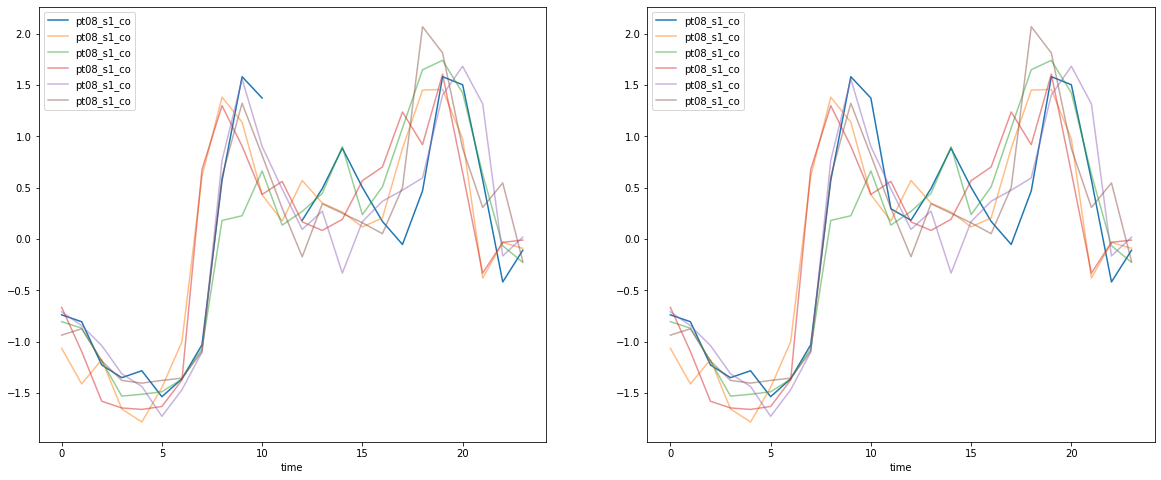

In [88]:
day=date
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
#Abbiamo bisogno di un dataset senza differenza su asse x solo per i plot
dfscale2[dfscale2['date']==day].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax1)
for matchingday in dfser.loc[(day)][['date']].values:
    dfscale2[dfscale2['date']==matchingday.item()].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax1,alpha=0.5)
dfscale3[dfscale3['date']==day].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax2)
for matchingday in dfser.loc[(day)][['date']].values:
    dfscale2[dfscale2['date']==matchingday.item()].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax2,alpha=0.5)
plt.show()

In [89]:
listamean

[0.2954144176670548]

In [90]:
listamean

[0.2954144176670548]

In [91]:
dfnew[dfnew['date']=='2004-04-01'].time.iloc[0]

[14, 15, 16]

In [92]:
dfnew

date                                      time  consecutive  count
21   2004-04-01                              [14, 15, 16]         True      3
28   2004-04-08                                      [23]         True      1
74   2004-05-25                      [19, 20, 21, 22, 23]         True      5
75   2004-05-26               [0, 1, 2, 3, 4, 5, 6, 7, 8]         True      9
99   2004-06-19  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]         True     10
100  2004-06-21                              [0, 1, 2, 3]         True      4
140  2004-07-31                                       [0]         True      1
149  2004-08-09                          [16, 17, 18, 19]         True      4
166  2004-08-28                                 [0, 1, 2]         True      3
176  2004-09-07                                      [23]         True      1
199  2004-10-01                                      [14]         True      1
273  2004-12-14              [17, 18, 19, 20, 21, 22, 23]         True      7
280  2004-12-24                      [19, 20, 21, 22, 23]         True      5
289  2005-01-02                              [21, 22, 23]         True      3
290  2005-01-05                                       [0]         True      1
313  2005-01-28              [17, 18, 19, 20, 21, 22, 23]         True      7
314  2005-01-29                                    [0, 1]         True      2
324  2005-02-08              [17, 18, 19, 20, 21, 22, 23]         True      7
352  2005-03-11                                      [11]         True      1

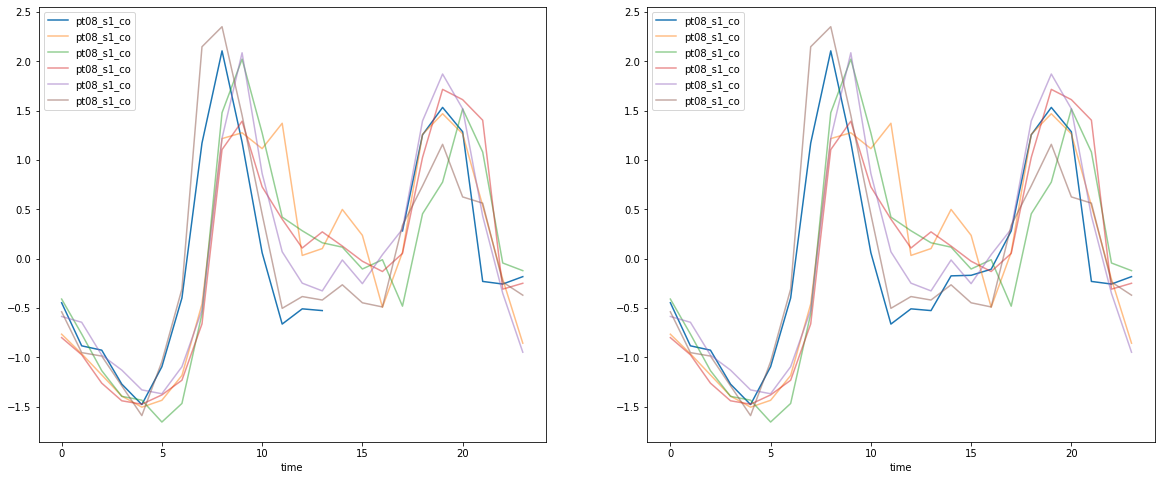

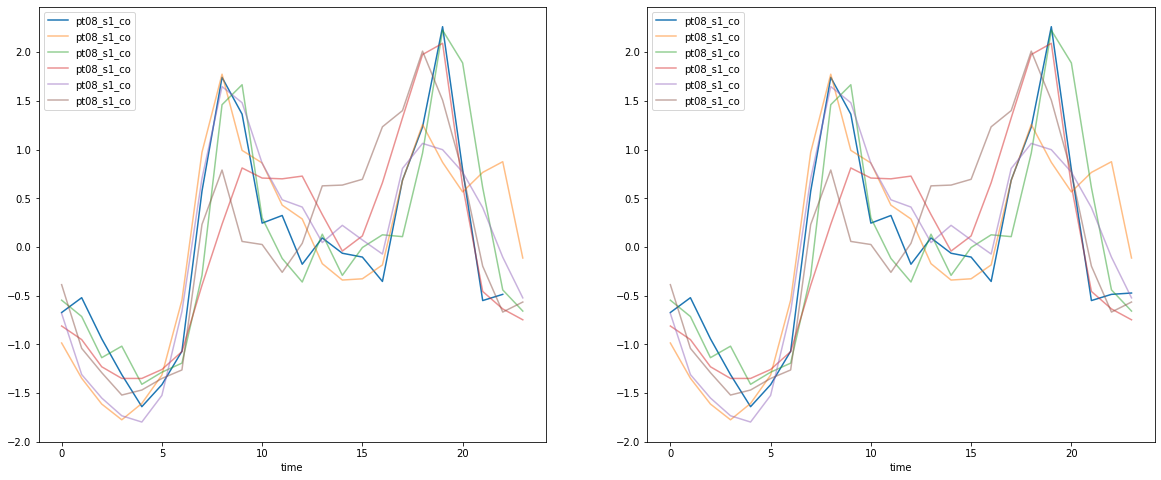

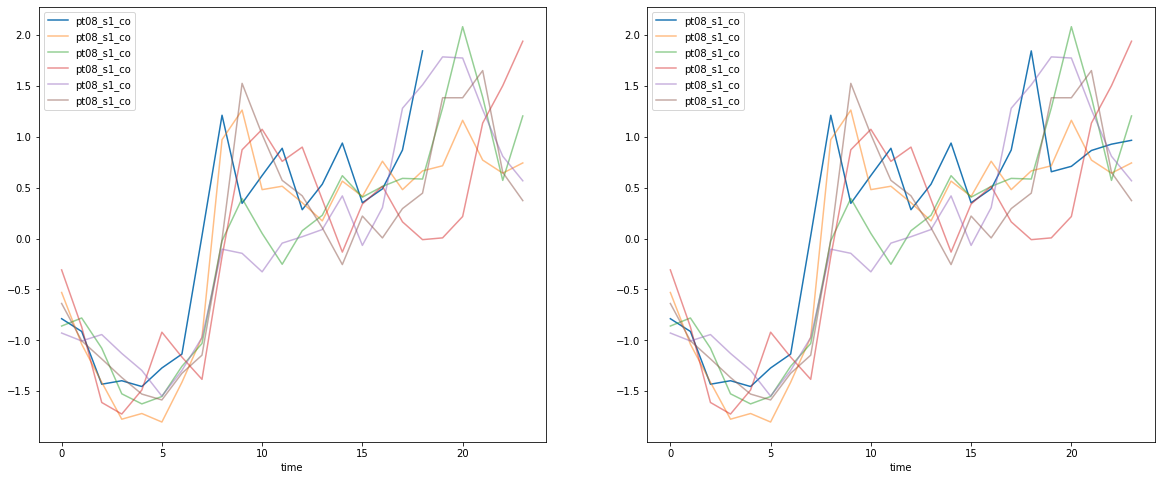

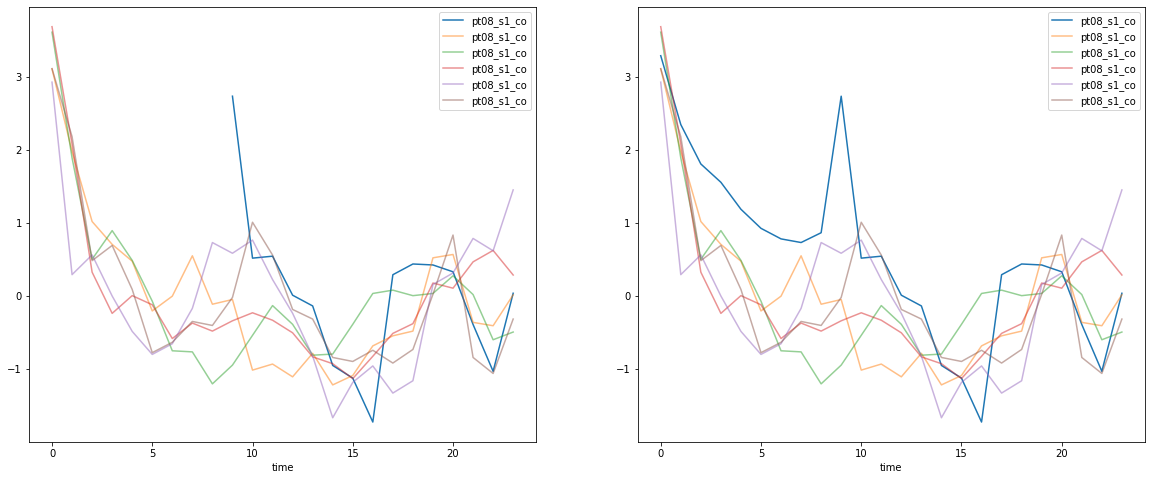

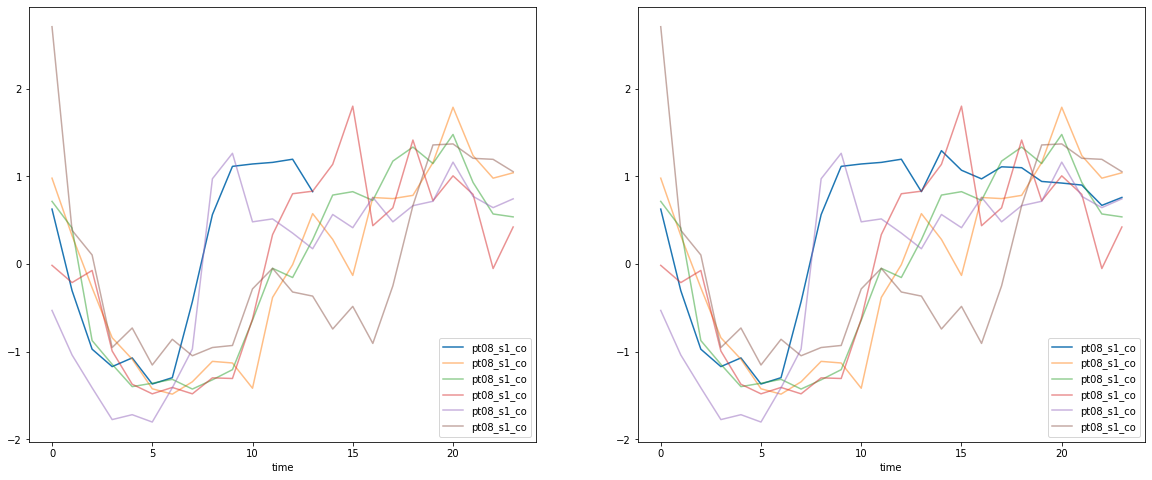

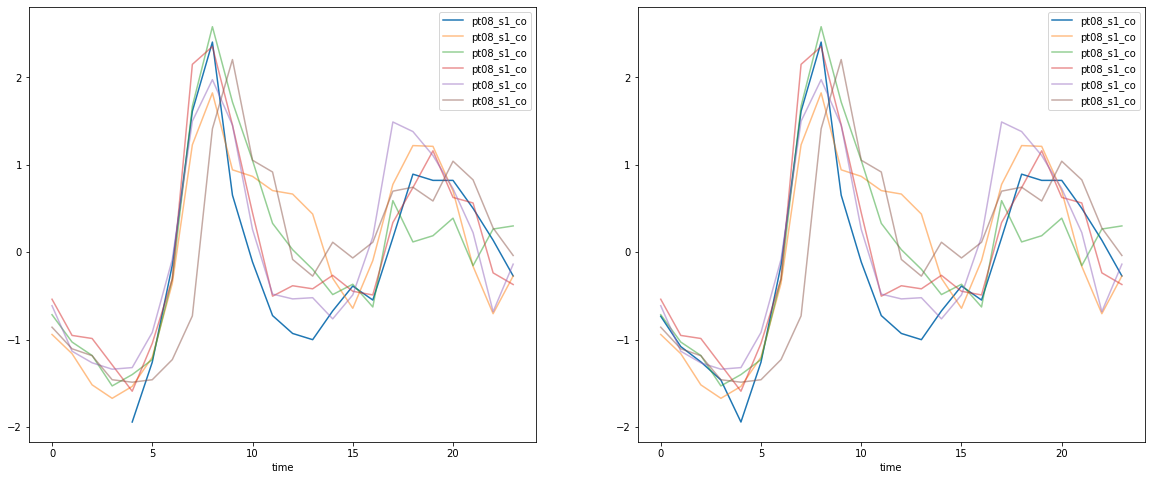

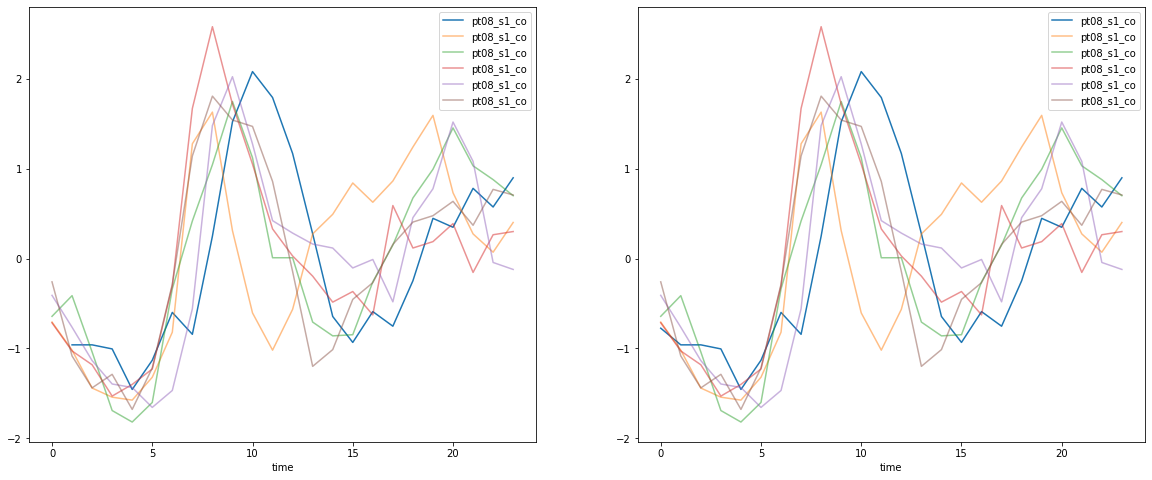

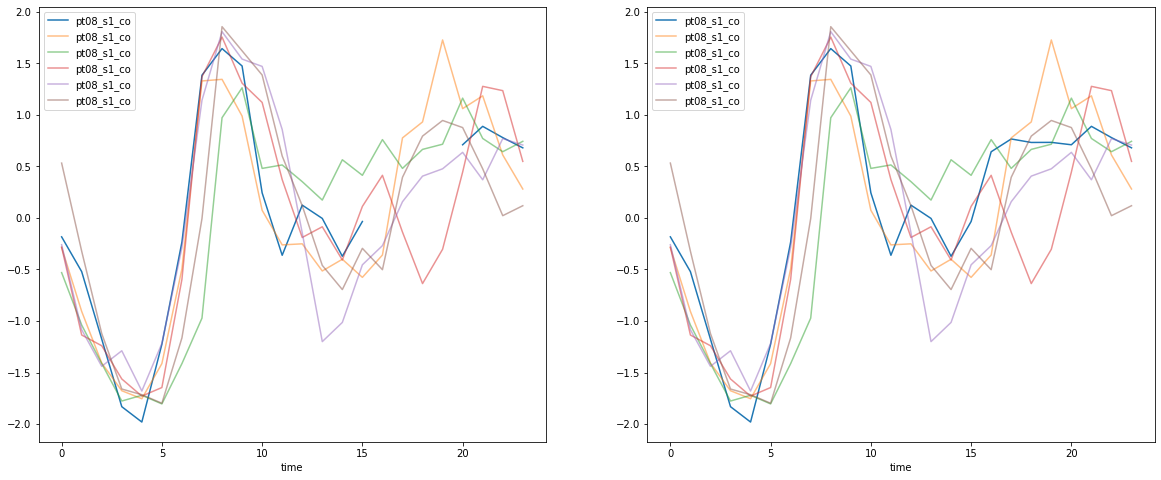

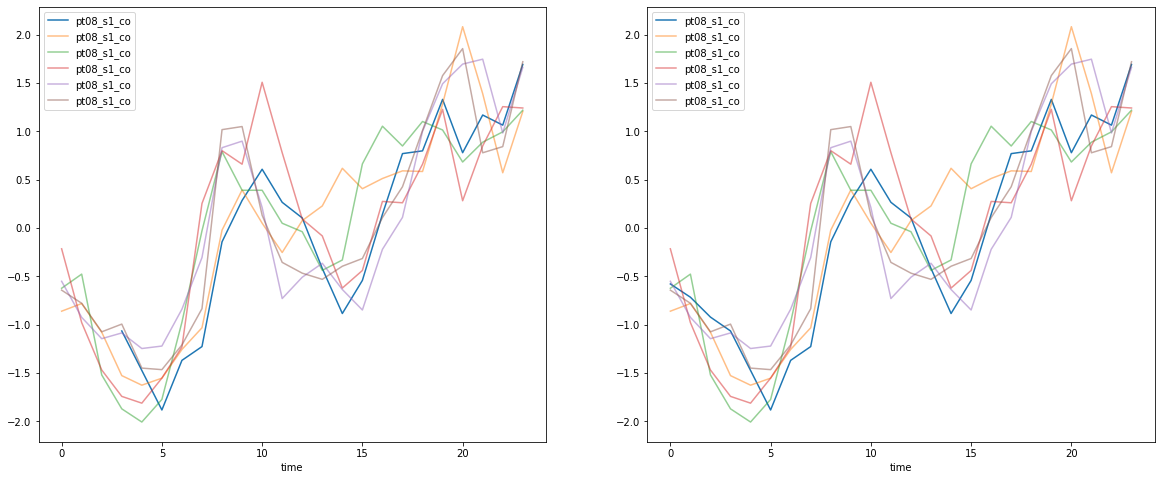

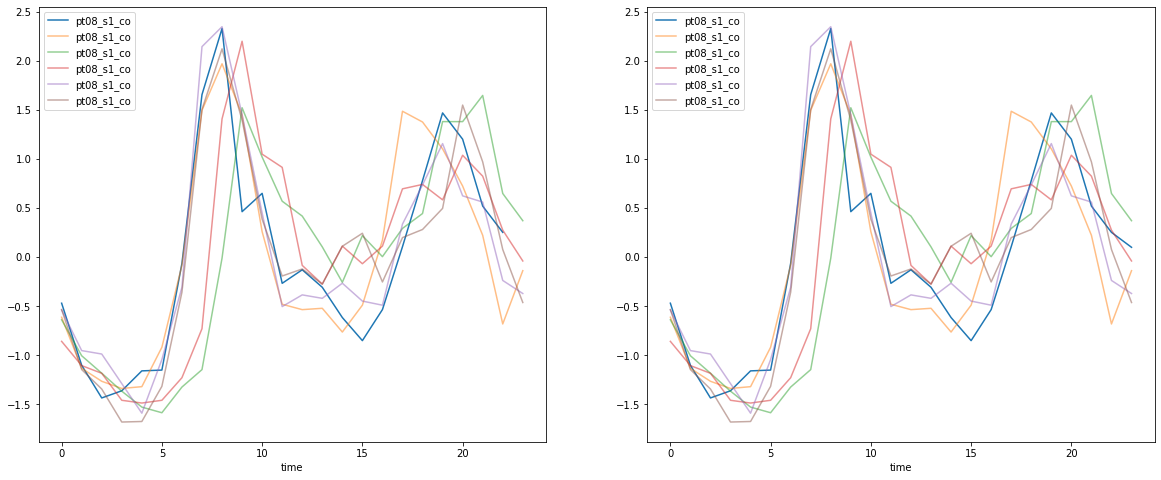

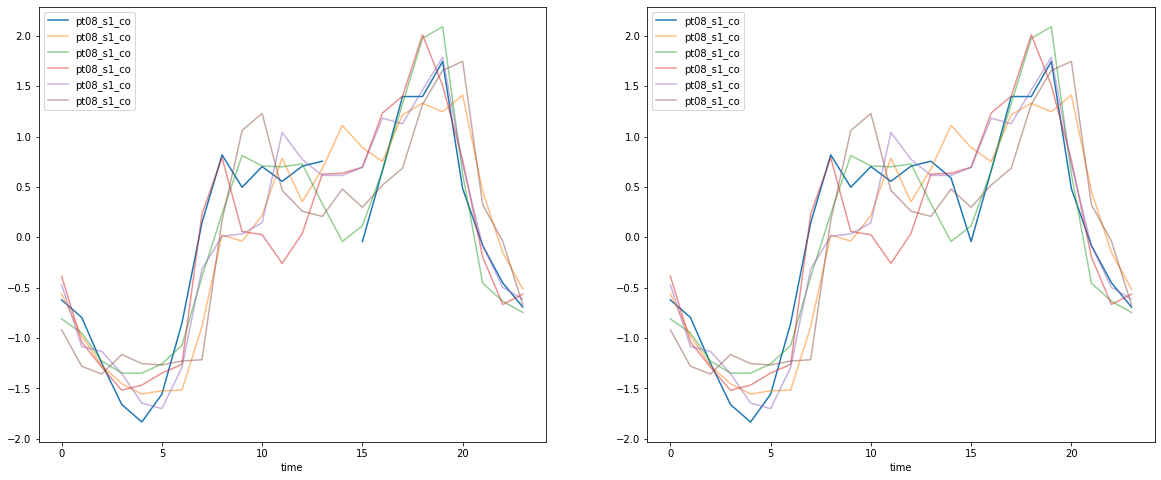

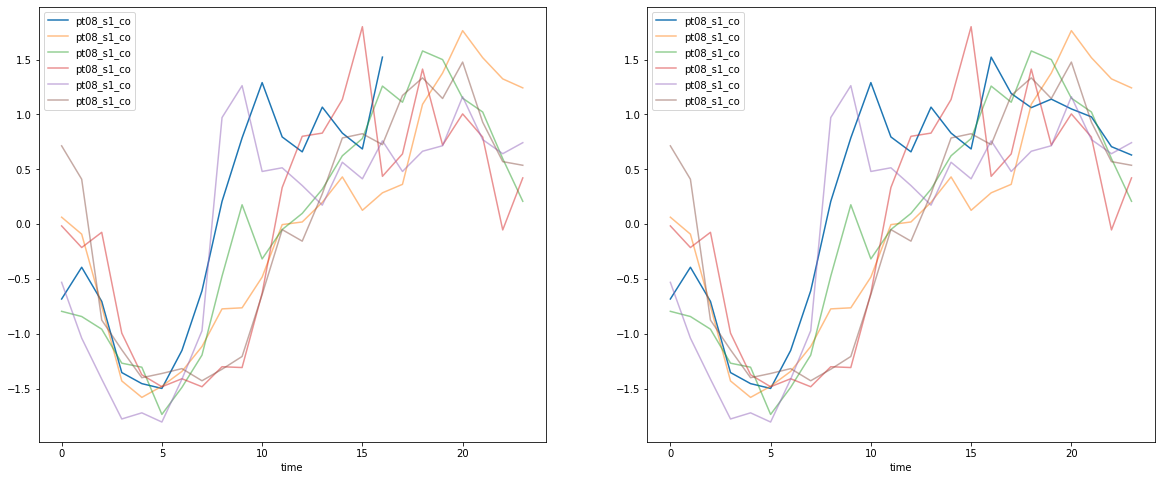

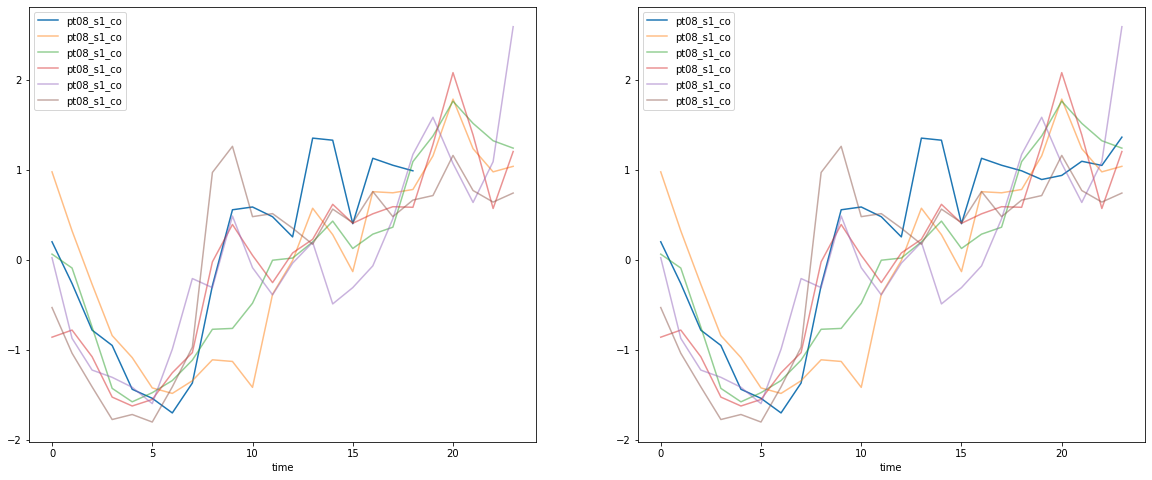

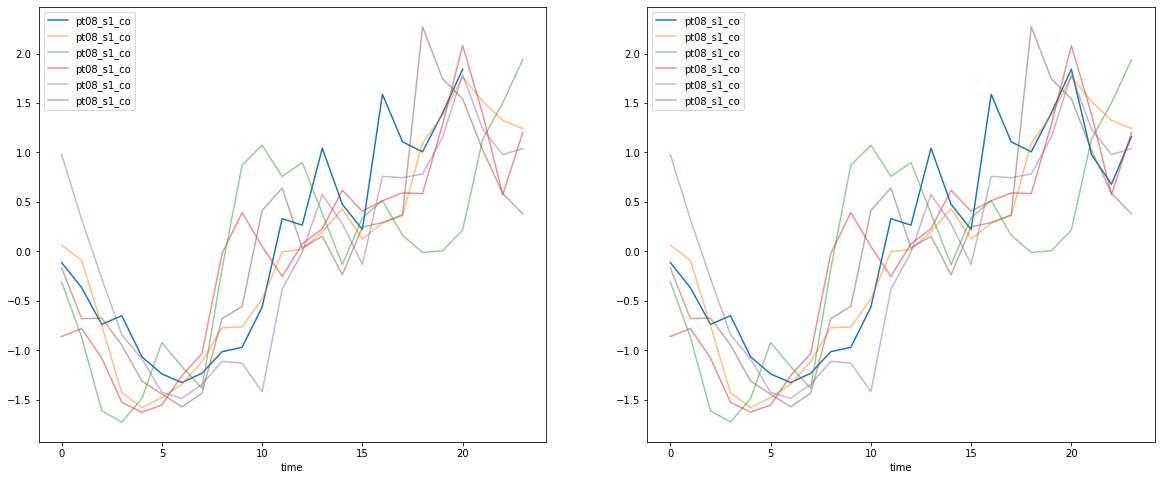

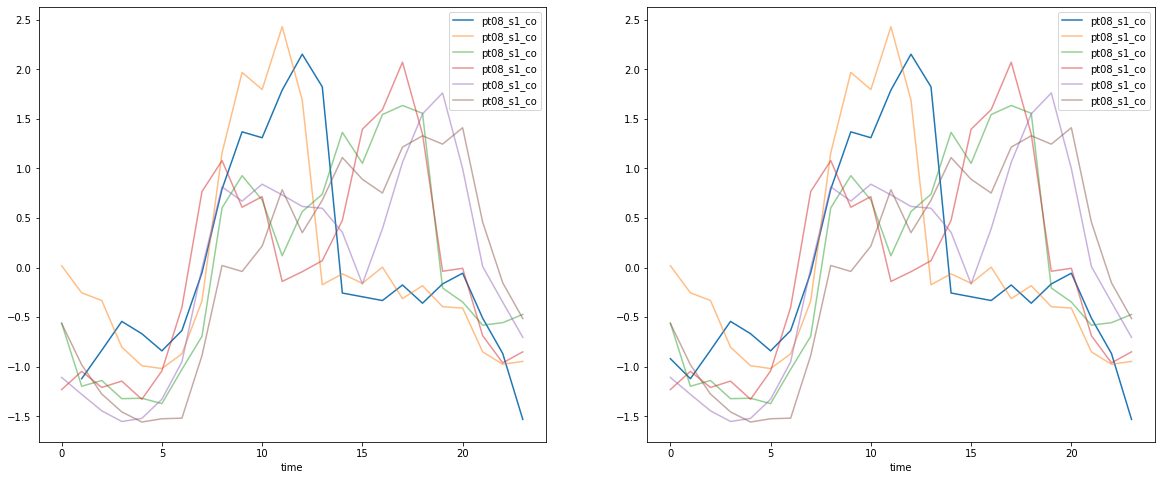

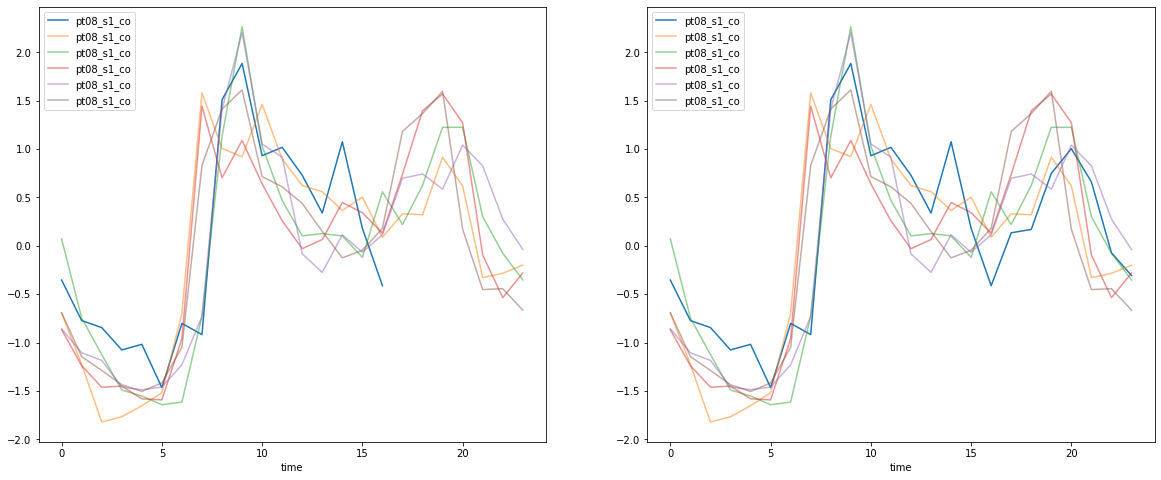

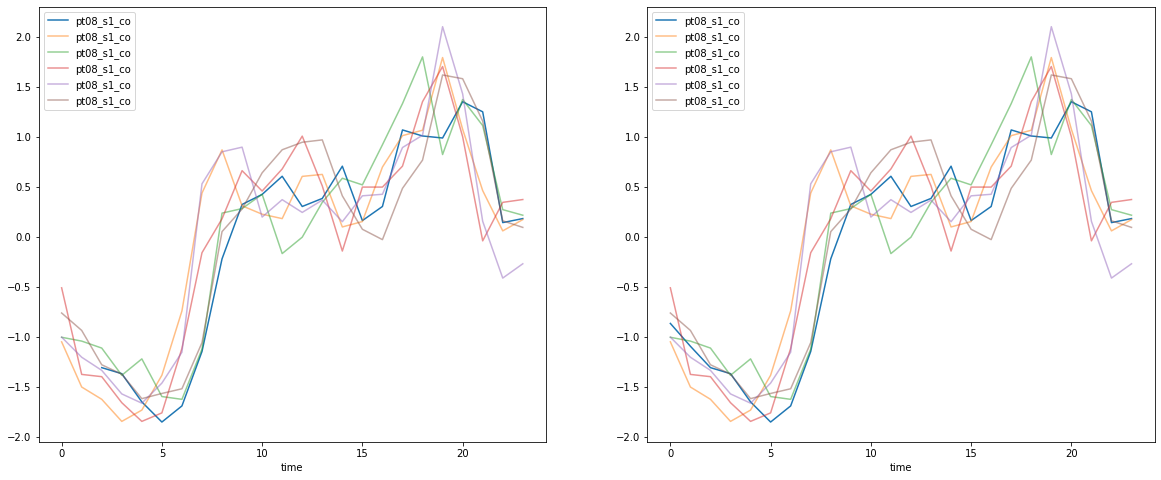

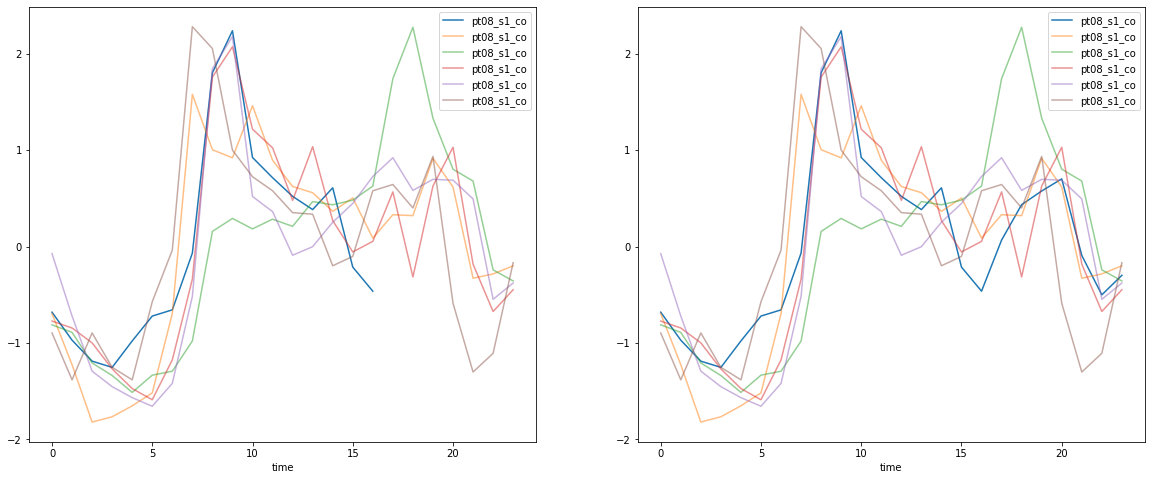

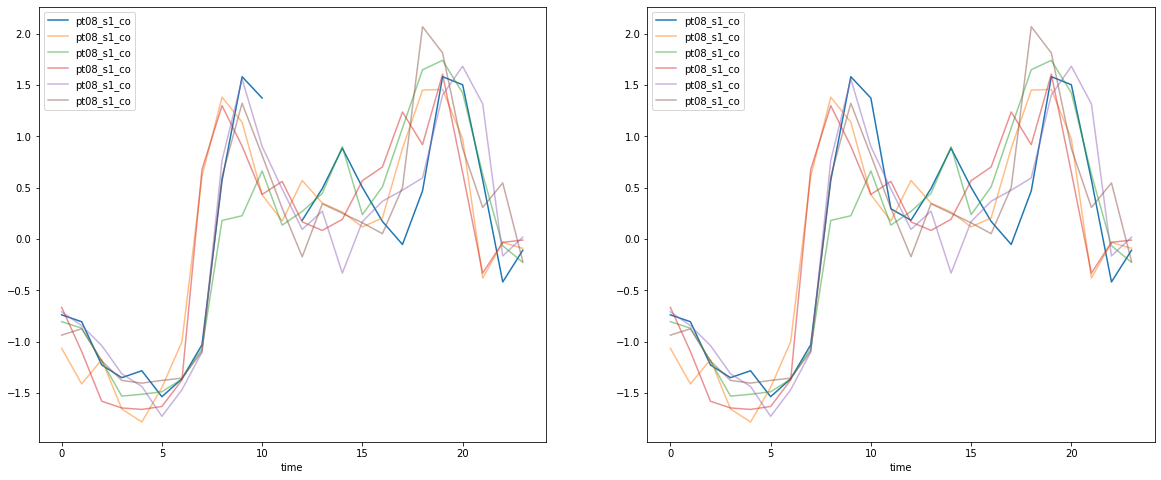

In [93]:
for day in dfnew['date']:
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #Abbiamo bisogno di un dataset senza differenza su asse x solo per i plot
    dfscale2[dfscale2['date']==day].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax1)
    for matchingday in dfser.loc[(day)][['date']].values:
        dfscale2[dfscale2['date']==matchingday.item()].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax1,alpha=0.5)
    dfscale3[dfscale3['date']==day].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax2)
    for matchingday in dfser.loc[(day)][['date']].values:
        dfscale2[dfscale2['date']==matchingday.item()].loc[:,['time','pt08_s1_co']].set_index('time').plot(ax=ax2,alpha=0.5)
    plt.show()  

In [98]:
#IN ORDER TO SAVE THE DATASET WITH NO MISSING VALUES

dfscale3.to_csv('C:/Users/Christian/Desktop/Università/DATA SCIENCE/DA DARE/3. DM II/uci-air-quality/uci-air-quality/data/dfscaledforclassification.csv')

In [97]:
dfscale3.isna().any()

date          False
time          False
pt08_s1_co    False
dtype: bool

# Clustering

In [63]:
from scipy.stats import mode
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

In [64]:
dfscale2

date  time  pt08_s1_co
0     2004-03-11   0.0   -0.284438
1     2004-03-11   1.0   -0.520000
2     2004-03-11   2.0   -0.721911
3     2004-03-11   3.0   -1.125732
4     2004-03-11   4.0   -1.120925
...          ...   ...         ...
9019  2005-04-03  19.0    2.597988
9020  2005-04-03  20.0    1.935398
9021  2005-04-03  21.0    1.175367
9022  2005-04-03  22.0    1.311783
9023  2005-04-03  23.0    1.155879

[9024 rows x 3 columns]

In [65]:
dnomissing.index=np.arange(0,len(dnomissing),1) #substitute indices with numbers from 1 until the end of the range
#I need a matrix just for the clustering. Each row must be a ts and you need the 24 values
#First I need to create a df with the lines and the times. They you fill it up
m=dnomissing['date'].unique()
n=dnomissing['time'].unique()
X=pd.DataFrame(columns=[j for j in n], index=[i for i in m])
#Until here you create the matrix with all NaN, then you can fill it up
for i in range(len(dnomissing['pt08_s1_co'])):
    X.iloc[i//24][i%24]=dnomissing['pt08_s1_co'][i]
X

0.0        1.0        2.0        3.0       4.0       5.0   \
2004-03-11  -0.284438      -0.52  -0.721911   -1.12573  -1.12092 -0.856518   
2004-03-12  -0.737281  -0.868895   -1.07363   -1.43557  -1.64761  -1.58911   
2004-03-13  -0.294487  -0.782716  -0.852463   -0.92221  -1.06752  -2.04979   
2004-03-14   0.827077   0.587865  0.0281075 -0.0819303  -1.10576  -1.43109   
2004-03-15  -0.724324  -0.724324  -0.775293   -1.27139  -1.27139  -1.28158   
...               ...        ...        ...        ...       ...       ...   
2005-03-30  -0.546887   -1.12045   -1.34054   -1.86742  -1.51394  -1.36722   
2005-03-31  0.0367021 -0.0762275  -0.640875   -0.78392 -0.934492 -0.543003   
2005-04-01  -0.896748    -1.3833  -0.896748   -1.25355   -1.3833 -0.572378   
2005-04-02    1.89253   -1.35363   -1.43031   -1.81372  -1.94152  -1.25139   
2005-04-03  -0.510341  -0.295973  -0.422645  -0.588293  -1.28012  -1.66013   

                 6.0       7.0        8.0       9.0   ...       14.0  \
2004-03-11  -0.923822 -0.481541   0.427057   0.51359  ...   0.609738   
2004-03-12   -1.29664 -0.697066    1.11628  0.962731  ...  0.0194983   
2004-03-13   -1.34069  -1.27094  0.0309986   0.44948  ...  -0.718781   
2004-03-14   -1.36411  -1.59375  -0.986153 -0.603413  ...  -0.737372   
2004-03-15   -1.00295  -0.46948    1.17172   1.72898  ...  -0.177258   
...               ...       ...        ...       ...  ...        ...   
2005-03-30   -1.05376  0.960388    1.04709   1.42057  ...  -0.240097   
2005-03-31   0.450777   3.93654     1.3241  0.420663  ...  -0.512889   
2005-04-01 -0.0371674   2.28208    2.05502   1.00082  ...  -0.199352   
2005-04-02  -0.177857  0.793434   0.307789  0.205547  ... -0.0500556   
2005-04-03    -1.2996 -0.968308  -0.442133  0.395849  ...  -0.471365   

                15.0      16.0       17.0      18.0      19.0      20.0  \
2004-03-11  0.316487  0.229954   0.667427   1.61929   2.55673   1.90293   
2004-03-12   0.26079  0.099929 -0.0280289  0.834773  0.889612    2.0522   
2004-03-13 -0.526977 -0.143369 -0.0271238  0.827276   1.61774   1.62937   
2004-03-14 -0.493376  0.463474   0.367789  0.559159   2.13796   2.56854   
2004-03-15 -0.459286 -0.455888 -0.0243518   1.57947   1.99741   1.50471   
...              ...       ...        ...       ...       ...       ...   
2005-03-30 -0.240097  0.113379    1.10044   1.32053   1.69402   1.14713   
2005-03-31  -0.33973 -0.354787   0.443249  0.571236  0.706751 -0.241858   
2005-04-01 -0.102041  0.579136    0.64401  0.400732  0.935943 -0.588596   
2005-04-02  0.231108  0.486711    1.43244   1.43244   1.15128  0.870115   
2005-04-03 -0.247253 -0.130326  -0.276485  0.327641   2.59799    1.9354   

                21.0        22.0      23.0  
2004-03-11  0.330909    -1.34207  -1.59205  
2004-03-12    1.1565    0.739718   1.44531  
2004-03-13   1.68749    0.658721  0.507603  
2004-03-14  0.951468   -0.177615 -0.058009  
2004-03-15  0.485337  -0.0447393  -1.05392  
...              ...         ...       ...  
2005-03-30  0.160065   -0.266774  -0.10671  
2005-03-31 -0.851677   -0.919435 -0.919435  
2005-04-01  -1.30221    -1.10759 -0.166915  
2005-04-02 -0.152297  0.00106501  0.333349  
2005-04-03   1.17537     1.31178   1.15588  

[357 rows x 24 columns]

In [66]:
# #This if you want to check there actually are no missing values within the dataset
# X.isnull().sum()

### Euclidean Distance

In [67]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
# data_dist provides with a compressed array of distances between all the different points, you can turn it into a redundant
# matrix by using the squareform function. 
# data_link shows you which elements are merged (bottom-up) or which clusters are merged


We try different kinds of methods for clustering, test them out and then choose the best performing

In [68]:
#res = dendrogram(data_link, color_threshold=7.0)

In [69]:
dlink_avg_eucl = linkage(data_dist, method='average', metric='euclidean')
dlink_wgh_eucl = linkage(data_dist, method='weighted', metric='euclidean')
dlink_ctr_eucl = linkage(data_dist, method='centroid', metric='euclidean')
dlink_med_eucl = linkage(data_dist, method='median', metric='euclidean')
dlink_ward_eucl= linkage(data_dist, method='ward', metric='euclidean')

In [70]:
Z=linkage(X,'ward') #is equivalent to data_link

Considerare dal dataset quanti giorni sono all'interno del cluster, le fasce di temperatura/umidità, le fasce di inquinamento sia di co sia di altri inquinanti. Poi considerare parametri in base ai quali poter validare i diversi clustering, oltre al cophenet coefficient. 
Prendi il più grande cophenet coefficient (centroids) e fai lo stesso lavoro per di sopra. Fai lo stesso per dtw. Poi scrivi tutto e mandi tutto. Hai una sera e una notte per farlo. 

Prima cosa da capire: come riportare il clustering al giorno. 

In [71]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

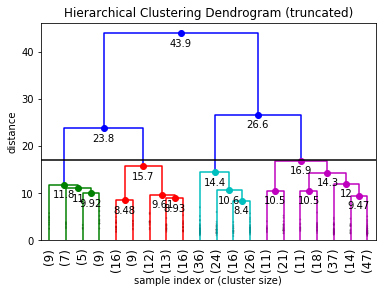

In [72]:
fig=plt.figure()
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=17
)
plt.show()
fig.savefig('C:/Users/Christian/Plots/ClusterEucl.png',dpi=150)

In [73]:
from scipy.cluster.hierarchy import fcluster
max_d = 17
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 4, 3, 1, 4, 4, 4, 4,
       3, 2, 4, 4, 4, 4, 1, 3, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 4, 3, 2, 4,
       4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 3, 4, 4, 2, 4, 4,
       4, 4, 4, 2, 1, 4, 4, 4, 2, 2, 4, 4, 2, 4, 4, 2, 1, 4, 4, 4, 4, 4,
       3, 1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 1, 1, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4,
       4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       1, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 2,
       4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 2, 3, 3, 2, 3, 3, 4, 4, 4, 3, 2, 2,
       3, 3, 3, 3, 3, 2, 2, 3, 3, 4, 3, 4, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       2, 2, 3, 2, 2, 4, 3, 3, 3, 3, 1, 2, 4, 3, 2, 3, 3, 3, 2, 3, 1, 2,
       1, 3, 3, 3, 2, 2, 2, 3, 1, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       1, 3, 3, 1, 3, 3, 1, 2, 1, 3, 3, 3, 2, 3, 4,

In [74]:
whichcluster=pd.DataFrame(({'cluster':[b for b in clusters]}),index=[i for i in X.index])
whichcluster.index.name='date'
whichcluster.index=pd.to_datetime(whichcluster.index) #index must be of matching types if you need to merge two datasets
prova4=whichcluster['cluster']
#After these lines of codes you have the cluster label connected to the right index

In [75]:
nomissinggrouped=dwnm.groupby('date').describe()
nomissinggrouped=nomissinggrouped.xs('mean',axis=1,level=1,drop_level=False)
nomissinggrouped.columns=nomissinggrouped.columns.droplevel()
nomissinggrouped.columns=['hours','mean concentration','day','week','month']
nomissinggrouped=nomissinggrouped.iloc[:,1:]
nomissinggrouped=nomissinggrouped.join(prova4)
#After these lines the dataset has the cluster labels associated

### Dynamic Time Warping

In [76]:
dm = pdist(X, lambda u, v: d.dtw(u,v).distance)
dm

array([17.40765317, 14.03591784, 15.30650615, ..., 17.12724832,
       23.1792997 , 17.99947174])

In [77]:
dlink_avg_dtw = linkage(dm, method='average')
dlink_wgh_dtw = linkage(dm, method='weighted')
dlink_ctr_dtw = linkage(dm, method='centroid')
dlink_med_dtw = linkage(dm, method='median')
dlink_ward_dtw = linkage(dm, method='ward')

In [78]:
#Compare the different dendograms to understand whether there is a difference

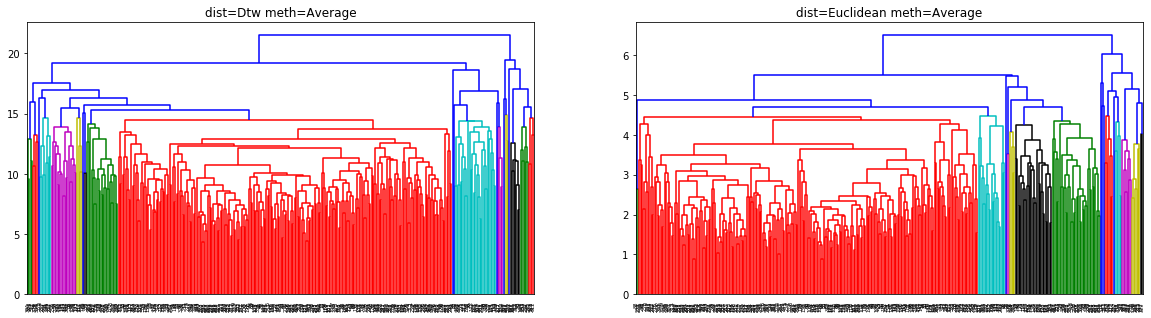

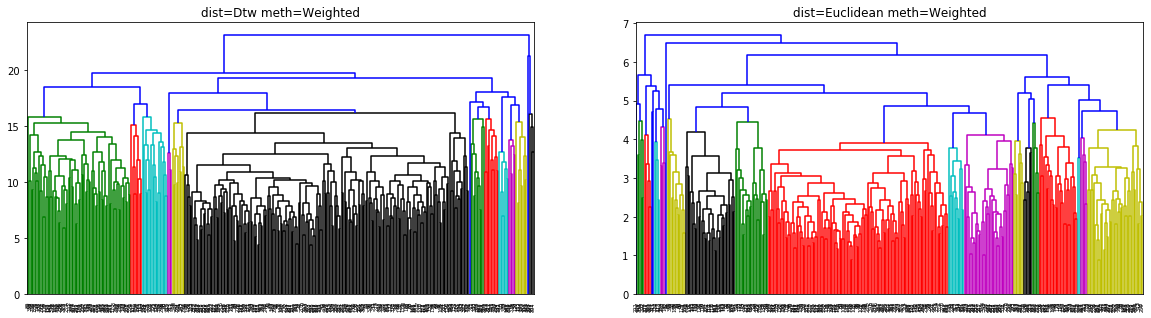

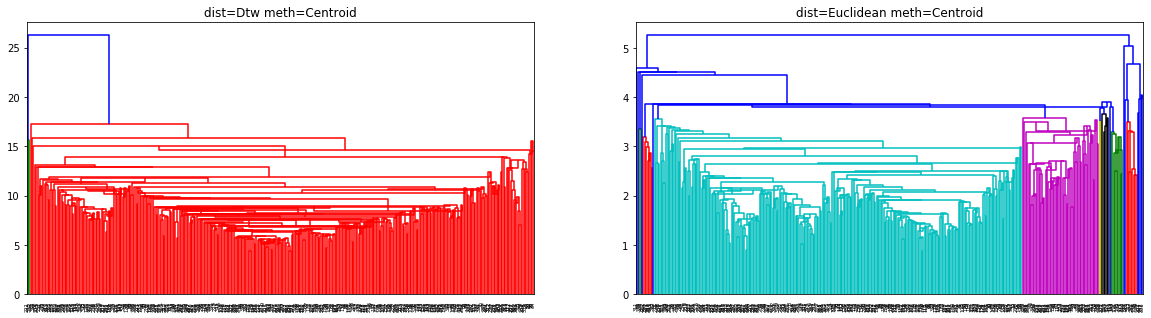

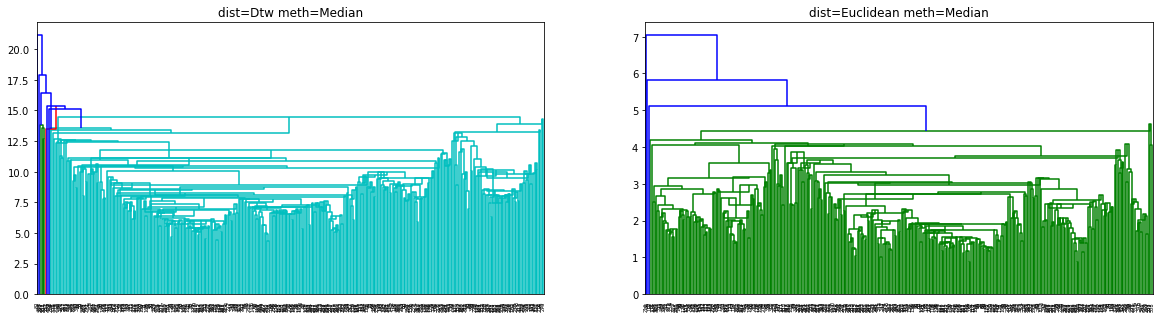

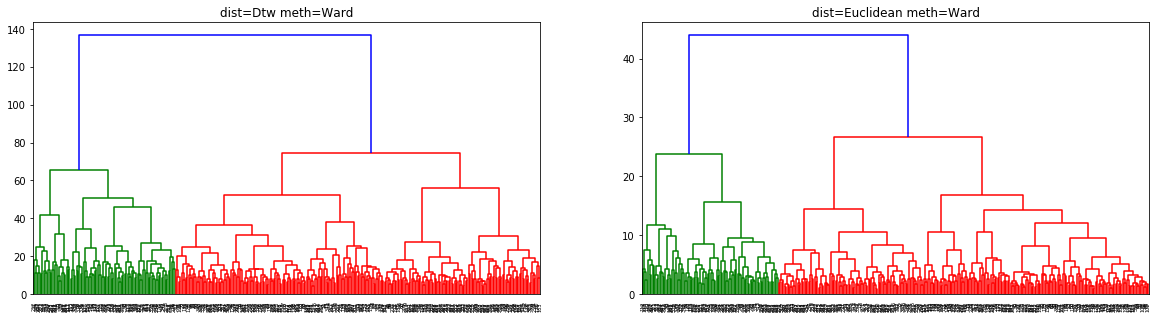

In [79]:
#Average
fig= plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(dlink_avg_dtw,ax=ax1)
ax1.title.set_text('dist=Dtw meth=Average')
dendrogram(dlink_avg_eucl,ax=ax2)
ax2.title.set_text('dist=Euclidean meth=Average')
fig.savefig('C:/Users/Christian/Plots/HClustAvg.png',dpi=150)
#Weighted
fig= plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(dlink_wgh_dtw,ax=ax1)
dendrogram(dlink_wgh_eucl,ax=ax2)
ax1.title.set_text('dist=Dtw meth=Weighted')
ax2.title.set_text('dist=Euclidean meth=Weighted')
fig.savefig('C:/Users/Christian/Plots/HClustWgh.png',dpi=150)
#Centroid
fig= plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(dlink_ctr_dtw,ax=ax1)
dendrogram(dlink_ctr_eucl,ax=ax2)
ax1.title.set_text('dist=Dtw meth=Centroid')
ax2.title.set_text('dist=Euclidean meth=Centroid')
fig.savefig('C:/Users/Christian/Plots/HClustCtr.png',dpi=150)
#Median
fig= plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(dlink_med_dtw,ax=ax1)
dendrogram(dlink_med_eucl,ax=ax2)
ax1.title.set_text('dist=Dtw meth=Median')
ax2.title.set_text('dist=Euclidean meth=Median')
fig.savefig('C:/Users/Christian/Plots/HClustMdn.png',dpi=150)
#Ward
fig= plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
dendrogram(dlink_ward_dtw,ax=ax1)
dendrogram(dlink_ward_eucl,ax=ax2)
ax1.title.set_text('dist=Dtw meth=Ward')
ax2.title.set_text('dist=Euclidean meth=Ward')
fig.savefig('C:/Users/Christian/Plots/HClustWard.png',dpi=150)
plt.show()

In [80]:
Z2=linkage(dm,'ward')

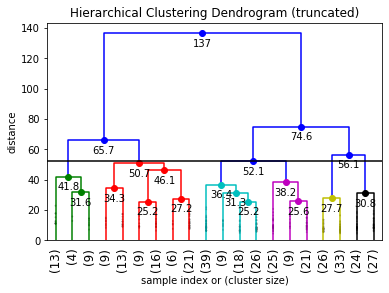

In [81]:
fig=plt.figure()
fancy_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    max_d=52.0
)
plt.show()
fig.savefig('C:/Users/Christian/Plots/ClusterDtw.png',dpi=150)

In [82]:
max_d = 56.2
clusters2 = fcluster(Z2, max_d, criterion='distance')
clusters2

array([3, 4, 4, 2, 3, 3, 4, 3, 3, 4, 2, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 4,
       4, 2, 3, 3, 3, 2, 2, 3, 3, 3, 4, 3, 2, 4, 3, 3, 3, 4, 4, 1, 2, 4,
       3, 4, 3, 4, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 4, 2, 2, 2, 3, 3,
       3, 3, 3, 4, 1, 3, 3, 3, 2, 2, 3, 4, 2, 3, 4, 2, 2, 4, 3, 4, 4, 3,
       4, 1, 4, 3, 3, 3, 3, 3, 4, 2, 3, 4, 2, 3, 3, 4, 3, 3, 2, 2, 4, 3,
       3, 4, 1, 2, 2, 3, 3, 3, 3, 3, 4, 2, 3, 3, 4, 3, 3, 2, 2, 3, 3, 3,
       4, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 4, 2, 4, 3, 4, 4, 2, 2,
       2, 3, 4, 3, 2, 3, 3, 3, 4, 4, 1, 1, 3, 4, 3, 4, 2, 3, 3, 4, 3, 3,
       4, 2, 3, 3, 3, 4, 3, 4, 2, 3, 4, 4, 4, 2, 2, 4, 4, 4, 3, 3, 4, 1,
       3, 3, 4, 4, 3, 3, 2, 4, 3, 4, 2, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 2,
       4, 3, 4, 4, 4, 2, 4, 3, 4, 3, 4, 3, 2, 4, 3, 4, 3, 3, 4, 2, 4, 4,
       2, 1, 4, 1, 2, 3, 3, 4, 4, 3, 1, 1, 3, 3, 4, 1, 4, 4, 2, 4, 1, 2,
       1, 3, 4, 4, 2, 2, 3, 3, 1, 3, 2, 2, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4,
       1, 4, 4, 1, 3, 4, 1, 3, 1, 4, 4, 3, 2, 4, 3,

In [83]:
whichcluster2=pd.DataFrame(({'cluster':[b for b in clusters2]}),index=[i for i in X.index])
whichcluster2.index.name='date'
whichcluster2.index=pd.to_datetime(whichcluster2.index) #index must be of matching types if you need to merge two datasets
prova4_2=whichcluster2['cluster']
#After these lines of codes you have the cluster label connected to the right index

In [84]:
nomissinggrouped2=dwnm.groupby('date').describe()
nomissinggrouped2=nomissinggrouped2.xs('mean',axis=1,level=1,drop_level=False)
nomissinggrouped2.columns=nomissinggrouped2.columns.droplevel()
nomissinggrouped2.columns=['hours','mean concentration','day','week','month']
nomissinggrouped2=nomissinggrouped2.iloc[:,1:]
nomissinggrouped2=nomissinggrouped2.join(prova4_2)
nomissinggrouped2
#After these lines the dataset has the cluster labels associated

mean concentration  day  week  month  cluster
date                                                     
2004-03-11         1244.166667  3.0  11.0    3.0        3
2004-03-12         1281.666667  4.0  11.0    3.0        4
2004-03-13         1330.666667  5.0  11.0    3.0        4
2004-03-14         1361.125000  6.0  11.0    3.0        2
2004-03-15         1452.166667  0.0  12.0    3.0        3
...                        ...  ...   ...    ...      ...
2005-03-30         1106.000000  2.0  13.0    3.0        3
2005-03-31         1008.125000  3.0  13.0    3.0        3
2005-04-01          903.291667  4.0  13.0    4.0        3
2005-04-02          890.958333  5.0  13.0    4.0        4
2005-04-03          981.375000  6.0  13.0    4.0        4

[357 rows x 5 columns]

In [85]:
gk.get_group(6)

NameError: name 'gk' is not defined

### Validation of the clusters

In [ ]:
gk=nomissinggrouped.groupby('cluster')
gk2=nomissinggrouped2.groupby('cluster')
fig= plt.figure(figsize=(20,5))
plt.title("Euclidean - Month")
ax1 = fig.add_subplot(1, 6, 1)
ax2 = fig.add_subplot(1, 6, 2)
ax3 = fig.add_subplot(1, 6, 3)
ax4 = fig.add_subplot(1, 6, 4)
ax5 = fig.add_subplot(1, 6, 5)
ax6 = fig.add_subplot(1, 6, 6)
gk.get_group(1)['month'].hist(color='red',ax=ax1)
gk.get_group(2)['month'].hist(color='blue',ax=ax2)
gk.get_group(3)['month'].hist(color='green',ax=ax3)
gk.get_group(4)['month'].hist(color='purple',ax=ax4)
gk.get_group(5)['month'].hist(color='fuchsia',ax=ax5)
gk.get_group(6)['month'].hist(color='yellow',ax=ax6)
gk2=nomissinggrouped2.groupby('cluster')
fig= plt.figure(figsize=(20,5))
plt.title("Dynamic Time Warping - Month")
ax1 = fig.add_subplot(1, 6, 1)
ax2 = fig.add_subplot(1, 6, 2)
ax3 = fig.add_subplot(1, 6, 3)
ax4 = fig.add_subplot(1, 6, 4)
ax5 = fig.add_subplot(1, 6, 5)
ax6 = fig.add_subplot(1, 6, 6)
gk2.get_group(1)['month'].hist(color='red',ax=ax1)
gk2.get_group(2)['month'].hist(color='blue',ax=ax2)
gk2.get_group(3)['month'].hist(color='green',ax=ax3)
gk2.get_group(4)['month'].hist(color='purple',ax=ax4)
gk2.get_group(5)['month'].hist(color='fuchsia',ax=ax5)
gk2.get_group(6)['month'].hist(color='yellow',ax=ax6)
#
#Days
fig= plt.figure(figsize=(20,5))
plt.title("Euclidean - Day of week")
ax1 = fig.add_subplot(1, 6, 1)
ax2 = fig.add_subplot(1, 6, 2)
ax3 = fig.add_subplot(1, 6, 3)
ax4 = fig.add_subplot(1, 6, 4)
ax5 = fig.add_subplot(1, 6, 5)
ax6 = fig.add_subplot(1, 6, 6)
gk.get_group(1)['day'].hist(color='red',ax=ax1)
gk.get_group(2)['day'].hist(color='blue',ax=ax2)
gk.get_group(3)['day'].hist(color='green',ax=ax3)
gk.get_group(4)['day'].hist(color='purple',ax=ax4)
gk.get_group(5)['day'].hist(color='fuchsia',ax=ax5)
gk.get_group(6)['day'].hist(color='yellow',ax=ax6)
gk2=nomissinggrouped2.groupby('cluster')
fig= plt.figure(figsize=(20,5))
plt.title("Dynamic Time Warping - Day of week")
ax1 = fig.add_subplot(1, 6, 1)
ax2 = fig.add_subplot(1, 6, 2)
ax3 = fig.add_subplot(1, 6, 3)
ax4 = fig.add_subplot(1, 6, 4)
ax5 = fig.add_subplot(1, 6, 5)
ax6 = fig.add_subplot(1, 6, 6)
gk2.get_group(1)['day'].hist(color='red',ax=ax1)
gk2.get_group(2)['day'].hist(color='blue',ax=ax2)
gk2.get_group(3)['day'].hist(color='green',ax=ax3)
gk2.get_group(4)['day'].hist(color='purple',ax=ax4)
gk2.get_group(5)['day'].hist(color='fuchsia',ax=ax5)
gk2.get_group(6)['day'].hist(color='yellow',ax=ax6)
#
# #Pollution
fig= plt.figure(figsize=(20,5))
plt.title("Euclidean - Pollution")
ax1 = fig.add_subplot(1, 6, 1)
ax2 = fig.add_subplot(1, 6, 2)
ax3 = fig.add_subplot(1, 6, 3)
ax4 = fig.add_subplot(1, 6, 4)
ax5 = fig.add_subplot(1, 6, 5)
ax6 = fig.add_subplot(1, 6, 6)
gk.get_group(1)['mean concentration'].hist(color='red',ax=ax1)
gk.get_group(2)['mean concentration'].hist(color='blue',ax=ax2)
gk.get_group(3)['mean concentration'].hist(color='green',ax=ax3)
gk.get_group(4)['mean concentration'].hist(color='purple',ax=ax4)
gk.get_group(5)['mean concentration'].hist(color='fuchsia',ax=ax5)
gk.get_group(6)['mean concentration'].hist(color='yellow',ax=ax6)
gk2=nomissinggrouped2.groupby('cluster')
fig= plt.figure(figsize=(20,5))
plt.title("Dynamic Time Warping - Pollution")
ax1 = fig.add_subplot(1, 6, 1)
ax2 = fig.add_subplot(1, 6, 2)
ax3 = fig.add_subplot(1, 6, 3)
ax4 = fig.add_subplot(1, 6, 4)
ax5 = fig.add_subplot(1, 6, 5)
ax6 = fig.add_subplot(1, 6, 6)
gk2.get_group(1)['mean concentration'].hist(color='red',ax=ax1)
gk2.get_group(2)['mean concentration'].hist(color='blue',ax=ax2)
gk2.get_group(3)['mean concentration'].hist(color='green',ax=ax3)
gk2.get_group(4)['mean concentration'].hist(color='purple',ax=ax4)
gk2.get_group(5)['mean concentration'].hist(color='fuchsia',ax=ax5)
gk2.get_group(6)['mean concentration'].hist(color='yellow',ax=ax6)

plt.show()

In [ ]:
gk=nomissinggrouped.groupby('cluster')
gk2=nomissinggrouped2.groupby('cluster')
fig= plt.figure(figsize=(20,5))
plt.title("Euclidean - Month")
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
gk.get_group(1)['month'].hist(color='red',ax=ax1)
gk.get_group(2)['month'].hist(color='blue',ax=ax2)
gk.get_group(3)['month'].hist(color='green',ax=ax3)
gk.get_group(4)['month'].hist(color='purple',ax=ax4)
fig.savefig('C:/Users/Christian/Plots/Euclmonth.png',dpi=150)
fig= plt.figure(figsize=(20,5))
plt.title("Dynamic Time Warping - Month")
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
gk2.get_group(1)['month'].hist(color='red',ax=ax1)
gk2.get_group(2)['month'].hist(color='blue',ax=ax2)
gk2.get_group(3)['month'].hist(color='green',ax=ax3)
gk2.get_group(4)['month'].hist(color='purple',ax=ax4)
fig.savefig('C:/Users/Christian/Plots/Dtwmonth.png',dpi=150)
#
#Days
fig= plt.figure(figsize=(20,5))
plt.title("Euclidean - Day of week")
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
gk.get_group(1)['day'].hist(color='red',ax=ax1)
gk.get_group(2)['day'].hist(color='blue',ax=ax2)
gk.get_group(3)['day'].hist(color='green',ax=ax3)
gk.get_group(4)['day'].hist(color='purple',ax=ax4)
fig.savefig('C:/Users/Christian/Plots/Eucldayof.png',dpi=150)
fig= plt.figure(figsize=(20,5))
plt.title("Dynamic Time Warping - Day of week")
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
gk2.get_group(1)['day'].hist(color='red',ax=ax1)
gk2.get_group(2)['day'].hist(color='blue',ax=ax2)
gk2.get_group(3)['day'].hist(color='green',ax=ax3)
gk2.get_group(4)['day'].hist(color='purple',ax=ax4)
fig.savefig('C:/Users/Christian/Plots/Dtwdayof.png',dpi=150)
#
#Pollution
fig= plt.figure(figsize=(20,5))
plt.title("Euclidean - Pollution")
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
gk.get_group(1)['mean concentration'].hist(color='red',ax=ax1)
gk.get_group(2)['mean concentration'].hist(color='blue',ax=ax2)
gk.get_group(3)['mean concentration'].hist(color='green',ax=ax3)
gk.get_group(4)['mean concentration'].hist(color='purple',ax=ax4)
fig.savefig('C:/Users/Christian/Plots/Euclpollution.png',dpi=150)
fig= plt.figure(figsize=(20,5))
plt.title("Dynamic Time Warping - Pollution")
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
gk2.get_group(1)['mean concentration'].hist(color='red',ax=ax1)
gk2.get_group(2)['mean concentration'].hist(color='blue',ax=ax2)
gk2.get_group(3)['mean concentration'].hist(color='green',ax=ax3)
gk2.get_group(4)['mean concentration'].hist(color='purple',ax=ax4)
fig.savefig('C:/Users/Christian/Plots/DtwPollution.png',dpi=150)

plt.show()

In [ ]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(squareform(data_dist))
print ("Stress value: ", pos.stress_)

# Assign colors based on clusters
cols = ['lightgray', 'red', 'green', 'orange', 'blue']
cc = [ cols[l-1] for l in clusters]
#Second cluster
mds2 = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
cox = mds2.fit(squareform(dm))
print ("Stress value: ", pos.stress_)

# Assign colors based on clusters
cols = ['lightgray', 'red', 'green', 'orange', 'blue']
cc = [ cols[l-1] for l in clusters2]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
axes[0].scatter(pos.embedding_.T[0], pos.embedding_.T[1],color=cc, s=120)
axes[1].scatter(cox.embedding_.T[0], cox.embedding_.T[1],color=cc, s=120)
fig.savefig('C:/Users/Christian/Plots/MDS.png',dpi=150)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for a in np.unique(clusters):
    for i in range(len(clusters)):
        axes[a-1].plot(X.iloc[i],'r-' if clusters[i]==a else 'y-', )
plt.show()
fig.savefig('C:/Users/Christian/Plots/clustershoweucl.png',dpi=150)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for a in np.unique(clusters2):
    for i in range(len(clusters2)):
        axes[a-1].plot(X.iloc[i],'r-' if clusters2[i]==a else 'y-', )
plt.show()
fig.savefig('C:/Users/Christian/Plots/clustershow2.png',dpi=150)

In [ ]:
from operator import itemgetter
X_sort=sorted(zip(np.array(X),clusters),key=itemgetter(1))
X_sort2=[el[0] for el in X_sort]
X_sort3=pd.DataFrame(X_sort2)
plt.matshow(X_sort3, interpolation=None, aspect='auto')

In [ ]:
X_sortno=zip(np.array(X),clusters)
X_sortno2=[el[0] for el in X_sortno]
X_sortno3=pd.DataFrame(X_sortno2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
axes[0].matshow(X_sortno3, interpolation=None, aspect='auto')
axes[1].matshow(X_sort3, interpolation=None, aspect='auto')
plt.show()


In [ ]:
df24h_almostclean

In [ ]:
df24h_almostclean
dnomissing2=df24h_almostclean
for i in dfnew.date.index:
    dnomissing2=dnomissing2[dnomissing2['date'] != dfnew.date[i]]

In [ ]:
dnomissing2.index=np.arange(0,len(dnomissing2),1) #substitute indices with numbers from 1 until the end of the range
#I need a matrix just for the clustering. Each row must be a ts and you need the 24 values
#First I need to create a df with the lines and the times. They you fill it up
m=dnomissing2['date'].unique()
n=dnomissing2['time'].unique()
X=pd.DataFrame(columns=[j for j in n], index=[i for i in m])
#Until here you create the matrix with all NaN, then you can fill it up
for i in range(len(dnomissing2['pt08_s1_co'])):
    X.iloc[i//24][i%24]=dnomissing2['pt08_s1_co'][i]
X

In [ ]:
X.to_csv('C:/Users/Christian/Desktop/Università/DATA SCIENCE/DA DARE/3. DM II/uci-air-quality/uci-air-quality/data/matrix.csv')

In [ ]:
dfscale

In [ ]:
dfscalealmost = dfscale[~dfscale['date'].isin(listanan)]

In [ ]:
for i in dfnew.date.index:
    dfscalealmost=dfscalealmost[dfscalealmost['date'] != dfnew.date[i]]

In [ ]:
weekdf=dfscalealmost[(dfscalealmost['day of week']<=4)]

In [ ]:
weekdf=weekdf.iloc[:,:-2]

In [ ]:
weekdf

In [ ]:
weekdf.index=np.arange(0,len(weekdf),1) #substitute indices with numbers from 1 until the end of the range
#I need a matrix just for the clustering. Each row must be a ts and you need the 24 values
#First I need to create a df with the lines and the times. They you fill it up
m=weekdf['date'].unique()
n=weekdf['time'].unique()
X=pd.DataFrame(columns=[j for j in n], index=[i for i in m])
#Until here you create the matrix with all NaN, then you can fill it up
for i in range(len(weekdf['pt08_s1_co'])):
    X.iloc[i//24][i%24]=weekdf['pt08_s1_co'][i]
X

In [ ]:
X.to_csv('C:/Users/Christian/Desktop/Università/DATA SCIENCE/DA DARE/3. DM II/uci-air-quality/uci-air-quality/data/forpatternweek.csv')